**Research project: Analyse the drug expenditure**

Dataset: https://data.cms.gov/provider-summary-by-type-of-service/medicare-part-d-prescribers/medicare-part-d-prescribers-by-provider-and-drug/data

Data dictionary: https://data.cms.gov/resources/medicare-part-d-prescribers-by-provider-and-drug-data-dictionary

Healthy people 2020
disease info dataset


Total Record count : 2,523,187
- 2.5 million records

Since we have large number of records we are taking a sample of records from this and using that for analysis

**About Dataset:**

The Medicare Part D Prescribers by Provider and Drug dataset provides information on prescription drugs prescribed to Medicare beneficiaries enrolled in Part D by physicians and other health care providers. This dataset contains the total number of prescription fills that were dispensed and the total drug cost paid organized by prescribing National Provider Identifier (NPI), drug brand name (if applicable) and drug generic name.

**Research Questions:**

• How can a utility-driven clustering approach be developed to effectively identify clusters
that maximize the impact of healthcare policy implementations?

• What demographic and social determinants contribute to the patterns of prescription
drug use, and how do these patterns influence household healthcare expenditures when analyzed through multivariate analysis?

March 1st - https://www.csupom.com/conference.html

Robust transformation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

# To do list

as of now working for data with provider and drug
1. data preprocessing -
2. exploration
3. explore clustering models
    1. k means
    2. utiltiy based clusters
    3. scikit learn clustering models
4. Evaluate models - within and between cluster distance
, dollar amount and number of items in the cluster
5. table with model and metrics
6. utility based cluster


4 clusters with metrics table
save the file and share


# Python Library

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.metrics import pairwise
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import entropy


#Download data from API

Reading the data from API - retrieving 30,000 records from which randomnly select 10,000 records for processing

In [ ]:
api_url = 'https://data.cms.gov/data-api/v1/dataset/ab29d858-269a-4d97-908f-a26b1cf95f61/data?offset=0&size=10000&distinct=1'

response = requests.get(api_url)

if response.status_code == 200:
    # Get information from the response headers
    records_per_page = int(response.headers.get('X-Records-Per-Page', 1000))
    print(f"Number of records per page: {records_per_page}")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


Number of records per page: 1000


In [ ]:
api_url = 'https://data.cms.gov/data-api/v1/dataset/ab29d858-269a-4d97-908f-a26b1cf95f61/data'
sample_size = 30000

# Set up parameters for pagination and distinct
offset = 0
size = 1000  # API limit
distinct = 1

data = []

while len(data) < sample_size:
    params = {
        'offset': offset,
        'size': size,
        'distinct': distinct
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        page_data = response.json()

        # Check for duplicates before extending the data
        new_records = [record for record in page_data if record not in data]
        data.extend(new_records)

        # Check if there are more pages
        if len(page_data) < size:
            break
        else:
            offset += size
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        break

# Create DataFrame with the desired sample size
df = pd.DataFrame(data[:sample_size])

# Remove duplicate records and keep only the original occurrences
df_no_duplicates = df.drop_duplicates()

# Display the DataFrame without duplicates
print("DataFrame without Duplicates:")
print(len(df_no_duplicates))


DataFrame without Duplicates:
30000


In [ ]:
# csv with 30,000 records - downloaded and available in the files section
df.to_csv('df.csv', index=False)

**Question: do we need to select records for which tot_benes is not null**

as of now proceed with random 10,000 records

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# Filter records where Tot_Benes is not null
#df_filtered = df_total[df_total['Tot_Benes'].notnull()]

# Randomly select 10,000 records from the DataFrame
df_selected = df.sample(n=10000)

In [ ]:
df_selected.to_csv('df_selected.csv', index=False)

In [ ]:
from google.colab import files
files.download('df_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Start running from this step

# Data cleaning - preprocessing

Ignore the Api step - downloaded the data and saved in csv



In [ ]:
df_selected = pd.read_csv('df_selected.csv')

**Summary of the randomly selected Data**

There is no null object in the randomly selected data



In [ ]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Prscrbr_NPI            10000 non-null  int64  
 1   Prscrbr_Last_Org_Name  10000 non-null  object 
 2   Prscrbr_First_Name     10000 non-null  object 
 3   Prscrbr_City           10000 non-null  object 
 4   Prscrbr_State_Abrvtn   10000 non-null  object 
 5   Prscrbr_State_FIPS     10000 non-null  int64  
 6   Prscrbr_Type           10000 non-null  object 
 7   Prscrbr_Type_Src       10000 non-null  object 
 8   Brnd_Name              10000 non-null  object 
 9   Gnrc_Name              10000 non-null  object 
 10  Tot_Clms               10000 non-null  int64  
 11  Tot_30day_Fills        10000 non-null  float64
 12  Tot_Day_Suply          10000 non-null  int64  
 13  Tot_Drug_Cst           10000 non-null  float64
 14  Tot_Benes              4281 non-null   float64
 15  GE6

In [ ]:
df_selected.columns

Index(['Prscrbr_NPI', 'Prscrbr_Last_Org_Name', 'Prscrbr_First_Name',
       'Prscrbr_City', 'Prscrbr_State_Abrvtn', 'Prscrbr_State_FIPS',
       'Prscrbr_Type', 'Prscrbr_Type_Src', 'Brnd_Name', 'Gnrc_Name',
       'Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst',
       'Tot_Benes', 'GE65_Sprsn_Flag', 'GE65_Tot_Clms', 'GE65_Tot_30day_Fills',
       'GE65_Tot_Drug_Cst', 'GE65_Tot_Day_Suply', 'GE65_Bene_Sprsn_Flag',
       'GE65_Tot_Benes'],
      dtype='object')

Convert object to numeric

In [ ]:
# List of columns to convert to numeric
numeric_columns = ['Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst', 'Tot_Benes',
                    'GE65_Tot_Clms', 'GE65_Tot_30day_Fills', 'GE65_Tot_Drug_Cst', 'GE65_Tot_Day_Suply', 'GE65_Tot_Benes']

# Convert columns to numeric
df_selected[numeric_columns] = df_selected[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Check the updated data types
print(df_selected.dtypes)

Prscrbr_NPI                int64
Prscrbr_Last_Org_Name     object
Prscrbr_First_Name        object
Prscrbr_City              object
Prscrbr_State_Abrvtn      object
Prscrbr_State_FIPS         int64
Prscrbr_Type              object
Prscrbr_Type_Src          object
Brnd_Name                 object
Gnrc_Name                 object
Tot_Clms                   int64
Tot_30day_Fills          float64
Tot_Day_Suply              int64
Tot_Drug_Cst             float64
Tot_Benes                float64
GE65_Sprsn_Flag           object
GE65_Tot_Clms            float64
GE65_Tot_30day_Fills     float64
GE65_Tot_Drug_Cst        float64
GE65_Tot_Day_Suply       float64
GE65_Bene_Sprsn_Flag      object
GE65_Tot_Benes           float64
dtype: object


Checking for missing values

In [ ]:
missing_values = df_selected.isnull().sum()

# Display the count of missing values for each column
print("Missing values per column:")
print(missing_values)

Missing values per column:
Prscrbr_NPI                 0
Prscrbr_Last_Org_Name       0
Prscrbr_First_Name          0
Prscrbr_City                0
Prscrbr_State_Abrvtn        0
Prscrbr_State_FIPS          0
Prscrbr_Type                0
Prscrbr_Type_Src            0
Brnd_Name                   0
Gnrc_Name                   0
Tot_Clms                    0
Tot_30day_Fills             0
Tot_Day_Suply               0
Tot_Drug_Cst                0
Tot_Benes                5719
GE65_Sprsn_Flag          5392
GE65_Tot_Clms            4608
GE65_Tot_30day_Fills     4608
GE65_Tot_Drug_Cst        4608
GE65_Tot_Day_Suply       4608
GE65_Bene_Sprsn_Flag     1034
GE65_Tot_Benes           8966
dtype: int64


**Explanation for the missing values:**

**Tot_Benes:** The total number of unique Medicare Part D beneficiaries with at least one claim for the drug.
Counts fewer than 11 are suppressed and are indicated by a blank.

From the randomnly selected data we have 5719 records that is suppressed by blank .
**Question : can we impute those missing values or can we drop it ?** ** impute with 6

GE65_Sprsn_Flag - A flag that indicates the reason the GE65_Tot_Clms, GE65_Tot_30day_Fills,
GE65_Tot_Drug_Cst and GE65_Tot_Day_Suply variables are suppressed

As of now dropped the missing values in total beneficaries field

In [ ]:
len(df_selected)

10000

Descriptive Statistics

# Data Exploration

In [ ]:
descriptive_stats = df_selected.describe()
descriptive_stats

Prscrbr_NPI  Prscrbr_State_FIPS      Tot_Clms  Tot_30day_Fills  \
count  1.000000e+04        10000.000000  10000.000000      10000.00000   
mean   1.003048e+09           28.119600     50.085600         89.43709   
std    2.757935e+04           15.954778     82.366548        163.04911   
min    1.003000e+09            1.000000     11.000000         11.00000   
25%    1.003021e+09           13.000000     15.000000         21.00000   
50%    1.003048e+09           27.000000     24.000000         39.50000   
75%    1.003074e+09           42.000000     50.000000         85.00000   
max    1.003095e+09           72.000000   2820.000000       4365.80000   

       Tot_Day_Suply  Tot_Drug_Cst    Tot_Benes  GE65_Tot_Clms  \
count   10000.000000  1.000000e+04  4281.000000    5392.000000   
mean     2529.077800  8.640500e+03    31.108619      49.442878   
std      4814.040136  6.123645e+04    34.103747      88.637110   
min        11.000000  5.480000e+00    11.000000       0.000000   
25%       495.000000  2.585775e+02    14.000000      13.000000   
50%      1080.000000  6.672050e+02    20.000000      22.000000   
75%      2400.000000  2.397512e+03    34.000000      50.000000   
max    119333.000000  2.617473e+06   644.000000    2645.000000   

       GE65_Tot_30day_Fills  GE65_Tot_Drug_Cst  GE65_Tot_Day_Suply  \
count           5392.000000       5.392000e+03         5392.000000   
mean              92.666580       7.999174e+03         2651.460868   
std              180.939735       5.933868e+04         5319.005460   
min                0.000000       0.000000e+00            0.000000   
25%               18.000000       2.091375e+02          450.000000   
50%               37.150000       6.106150e+02         1050.000000   
75%               90.325000       2.215180e+03         2550.000000   
max             4105.900000       2.199576e+06       112496.000000   

       GE65_Tot_Benes  
count     1034.000000  
mean        36.144101  
std         47.325115  
min          0.000000  
25%         14.000000  
50%         19.000000  
75%         38.000000  
max        604.000000

data is skewed - transform and crete the cluster

In [ ]:
correlation_matrix = df_selected.corr()
correlation_matrix

<ipython-input-11-52ee47a0e57d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_selected.corr()


Prscrbr_NPI  Prscrbr_State_FIPS  Tot_Clms  \
Prscrbr_NPI              1.000000            0.063921 -0.007737   
Prscrbr_State_FIPS       0.063921            1.000000 -0.017782   
Tot_Clms                -0.007737           -0.017782  1.000000   
Tot_30day_Fills         -0.008644           -0.018446  0.921427   
Tot_Day_Suply           -0.007151           -0.021019  0.890967   
Tot_Drug_Cst             0.006119            0.009157  0.094479   
Tot_Benes               -0.005070           -0.010520  0.858513   
GE65_Tot_Clms           -0.001714           -0.014728  0.962595   
GE65_Tot_30day_Fills    -0.001931           -0.014766  0.878942   
GE65_Tot_Drug_Cst       -0.005024            0.007637  0.088583   
GE65_Tot_Day_Suply      -0.002100           -0.019001  0.850133   
GE65_Tot_Benes           0.033692            0.059862  0.844103   

                      Tot_30day_Fills  Tot_Day_Suply  Tot_Drug_Cst  Tot_Benes  \
Prscrbr_NPI                 -0.008644      -0.007151      0.006119  -0.005070   
Prscrbr_State_FIPS          -0.018446      -0.021019      0.009157  -0.010520   
Tot_Clms                     0.921427       0.890967      0.094479   0.858513   
Tot_30day_Fills              1.000000       0.994144      0.067128   0.808088   
Tot_Day_Suply                0.994144       1.000000      0.068007   0.773587   
Tot_Drug_Cst                 0.067128       0.068007      1.000000   0.070430   
Tot_Benes                    0.808088       0.773587      0.070430   1.000000   
GE65_Tot_Clms                0.924546       0.893451      0.069929   0.850556   
GE65_Tot_30day_Fills         0.983204       0.977696      0.044579   0.793680   
GE65_Tot_Drug_Cst            0.064774       0.064843      0.892194   0.067301   
GE65_Tot_Day_Suply           0.977997       0.983752      0.044904   0.766339   
GE65_Tot_Benes               0.810154       0.773352      0.121249   0.970352   

                      GE65_Tot_Clms  GE65_Tot_30day_Fills  GE65_Tot_Drug_Cst  \
Prscrbr_NPI               -0.001714             -0.001931          -0.005024   
Prscrbr_State_FIPS        -0.014728             -0.014766           0.007637   
Tot_Clms                   0.962595              0.878942           0.088583   
Tot_30day_Fills            0.924546              0.983204           0.064774   
Tot_Day_Suply              0.893451              0.977696           0.064843   
Tot_Drug_Cst               0.069929              0.044579           0.892194   
Tot_Benes                  0.850556              0.793680           0.067301   
GE65_Tot_Clms              1.000000              0.929950           0.092670   
GE65_Tot_30day_Fills       0.929950              1.000000           0.063046   
GE65_Tot_Drug_Cst          0.092670              0.063046           1.000000   
GE65_Tot_Day_Suply         0.898969              0.994347           0.062889   
GE65_Tot_Benes             0.896676              0.820688           0.144082   

                      GE65_Tot_Day_Suply  GE65_Tot_Benes  
Prscrbr_NPI                    -0.002100        0.033692  
Prscrbr_State_FIPS             -0.019001        0.059862  
Tot_Clms                        0.850133        0.844103  
Tot_30day_Fills                 0.977997        0.810154  
Tot_Day_Suply                   0.983752        0.773352  
Tot_Drug_Cst                    0.044904        0.121249  
Tot_Benes                       0.766339        0.970352  
GE65_Tot_Clms                   0.898969        0.896676  
GE65_Tot_30day_Fills            0.994347        0.820688  
GE65_Tot_Drug_Cst               0.062889        0.144082  
GE65_Tot_Day_Suply              1.000000        0.785522  
GE65_Tot_Benes                  0.785522        1.000000

Tot_30day_Fills,GE65_Tot_30day_Fills and Tot_Day_Suply are highly correlated - because it's derived from the total day supply

Tot_30day_Fills - The aggregate number of Medicare Part D standardized 30-day fills. The standardized 30-day
fill is derived from the number of days supplied on each Part D claim divided by 30.
Standardized 30-day fill values less than 1.0 were bottom-coded with a value of 1.0 and
standardized 30-day fill values greater than 12.0 were top-coded with a value of 12.0.

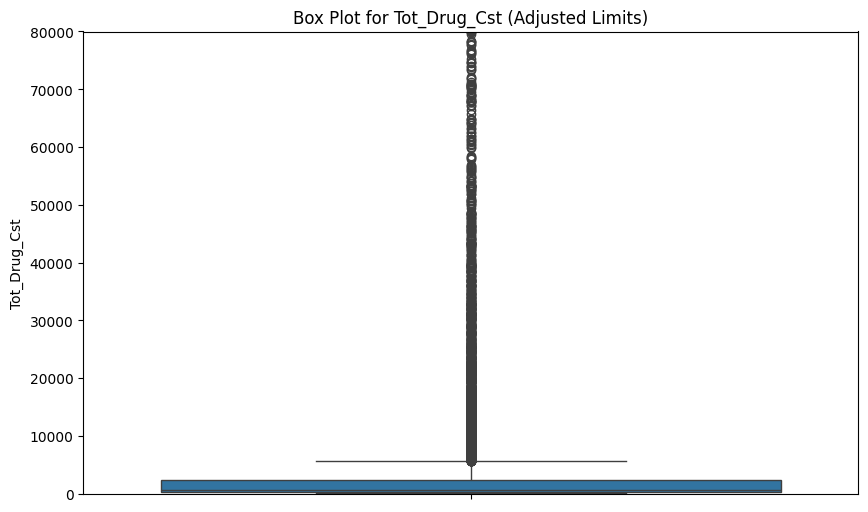

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_selected, y='Tot_Drug_Cst')
plt.ylim(bottom=0, top=80000)  # Adjust your_upper_limit accordingly
plt.title('Box Plot for Tot_Drug_Cst (Adjusted Limits)')
plt.show()

Scatter Plots for Numerical Variables

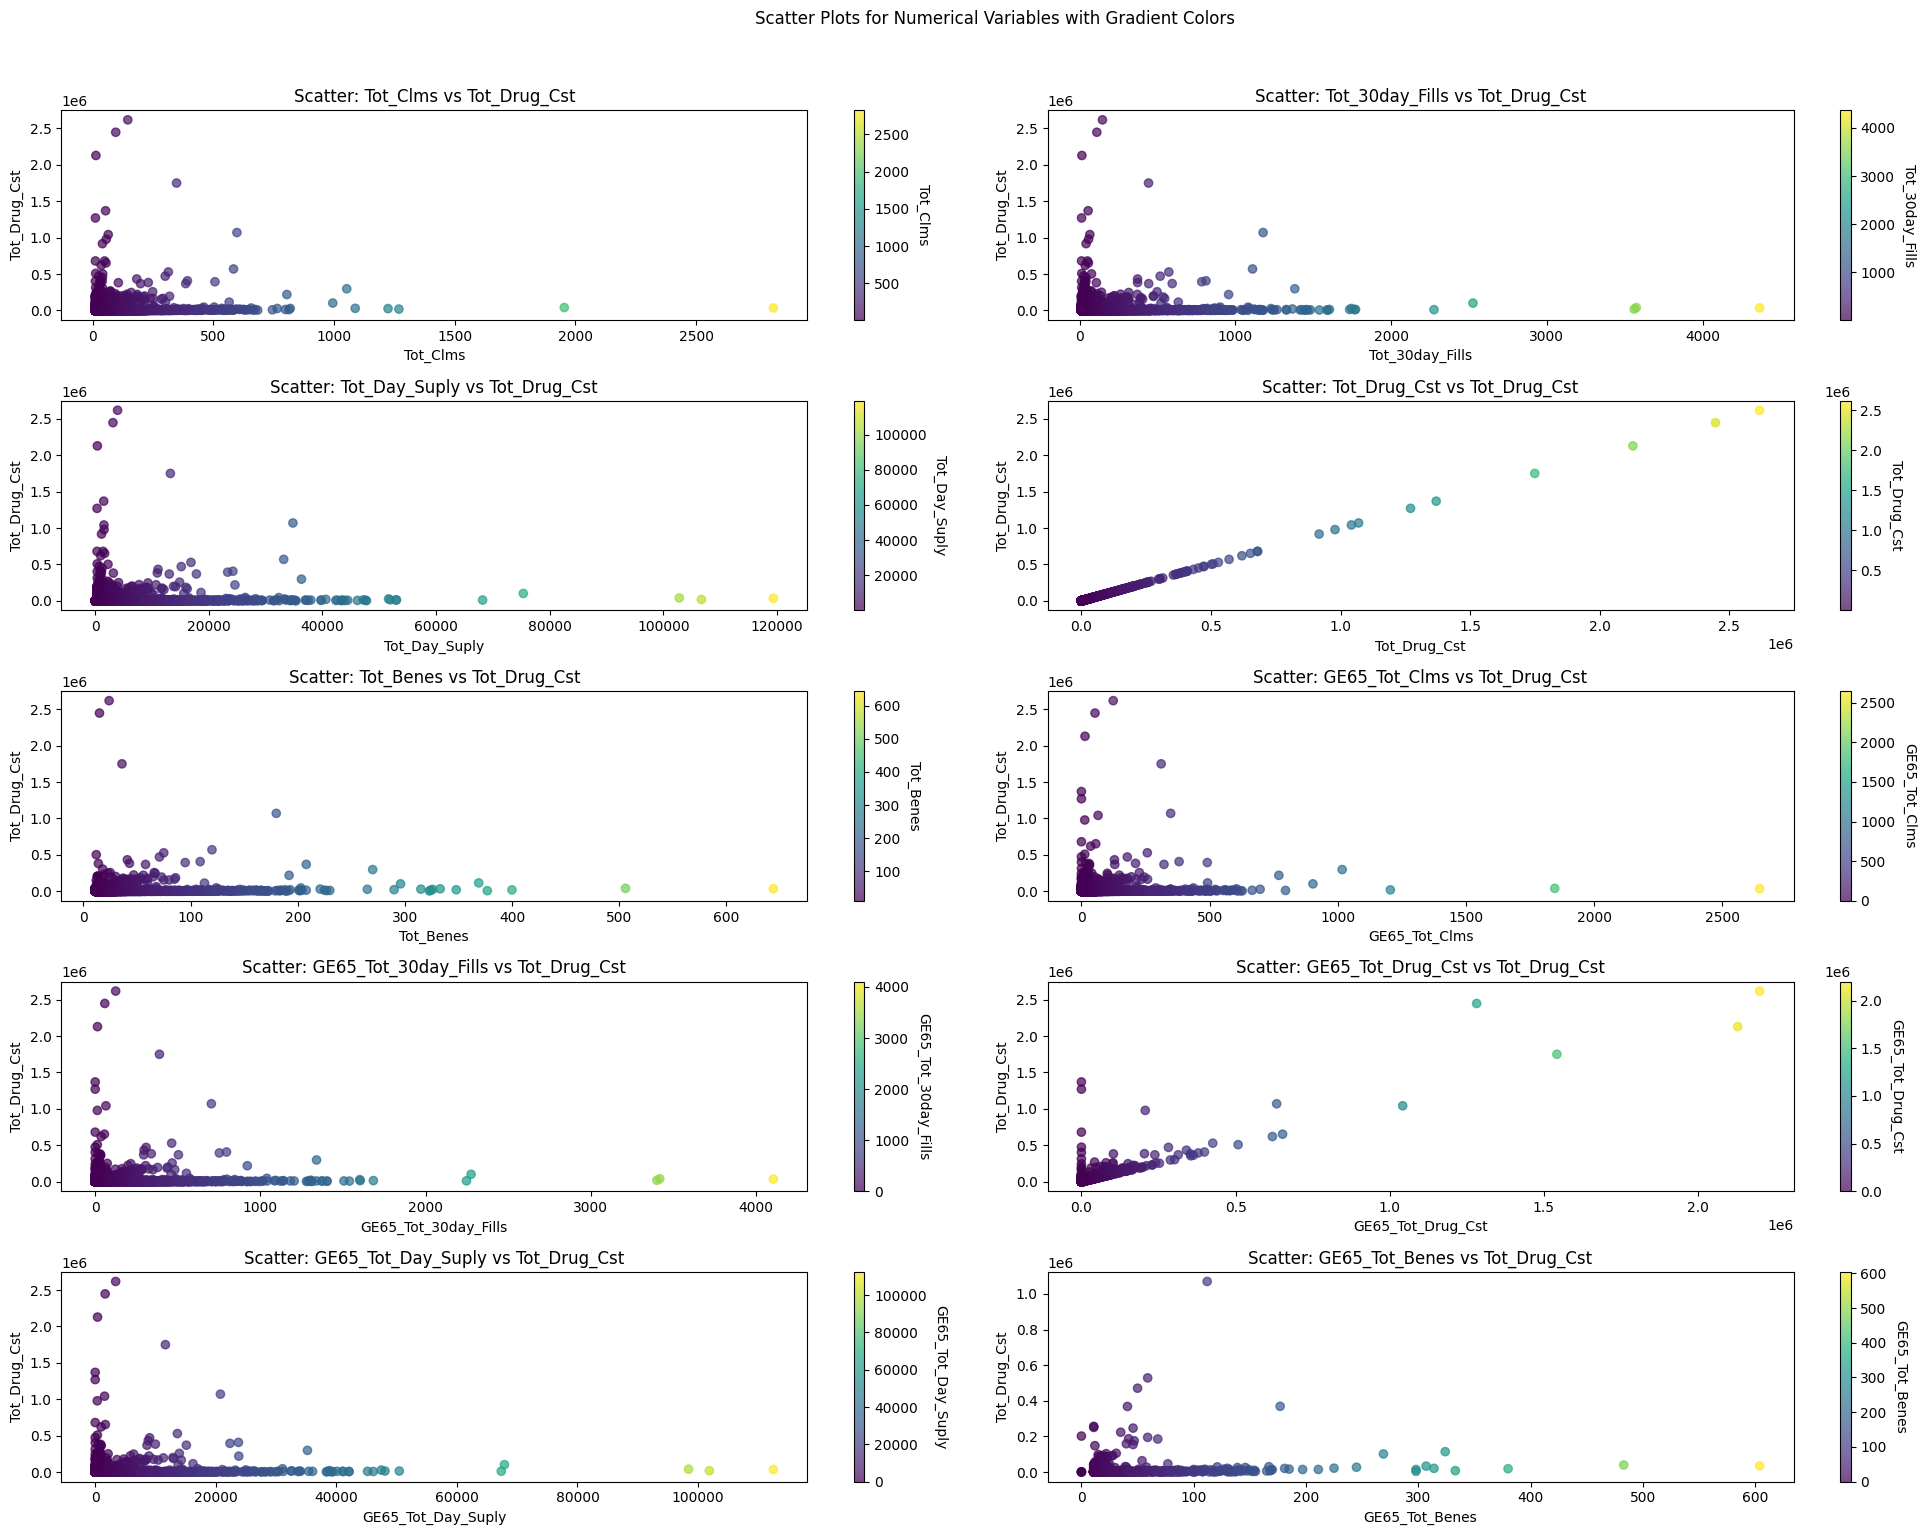

In [ ]:

numeric_columns = ['Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst', 'Tot_Benes',
                    'GE65_Tot_Clms', 'GE65_Tot_30day_Fills', 'GE65_Tot_Drug_Cst', 'GE65_Tot_Day_Suply', 'GE65_Tot_Benes']

# Number of rows and columns for subplots
rows = 5
cols = 2

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.suptitle('Scatter Plots for Numerical Variables with Gradient Colors', y=1.02)

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through numeric columns and create scatter plots with gradient colors
for i, column in enumerate(numeric_columns):
    scatter = axes[i].scatter(df_selected[column], df_selected['Tot_Drug_Cst'], c=df_selected[column], cmap='viridis', alpha=0.7)
    axes[i].set_title(f'Scatter: {column} vs Tot_Drug_Cst')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Tot_Drug_Cst')

    # Adding a colorbar for reference
    cbar = plt.colorbar(scatter, ax=axes[i])
    cbar.set_label(column, rotation=270, labelpad=15)

# Hide any unused subplots
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Total claim vs total drug cost - we can see patterns

*   Less number of claims with low cost
*   Less number of claims with high cost
*   high number of claims with low cost






In [ ]:
# Create a scatter plot for 'Gnrc_Name' vs 'Tot_Clms'
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_selected, x='Gnrc_Name', y='Tot_Clms', alpha=0.5)
plt.title('Scatter Plot: Gnrc_Name vs Tot_Clms')
plt.xlabel('Gnrc_Name')
plt.ylabel('Tot_Clms')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# Create a scatter plot for 'Gnrc_Name' vs 'Tot_Drug_Cst'
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_selected, x='Gnrc_Name', y='Tot_Drug_Cst', alpha=0.5)
plt.title('Scatter Plot: Gnrc_Name vs Tot_Drug_Cst')
plt.xlabel('Gnrc_Name')
plt.ylabel('Tot_Drug_Cst')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


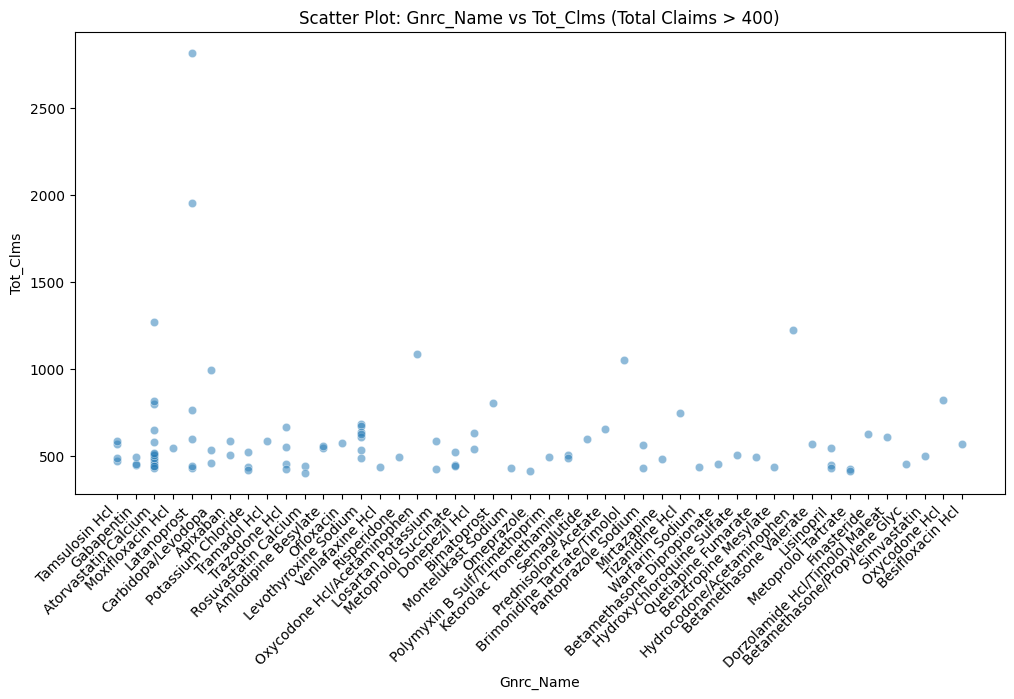

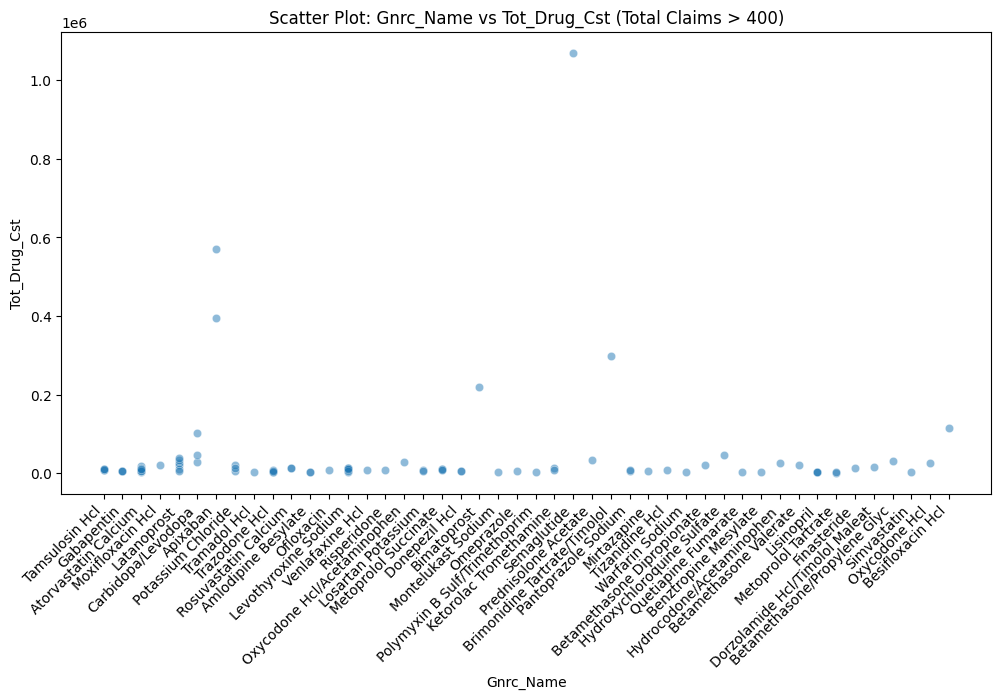

In [ ]:
# Filter DataFrame where Tot_Clms is greater than 400
filtered_df = df_selected[df_selected['Tot_Clms'] > 400]

# Create a scatter plot for 'Gnrc_Name' vs 'Tot_Clms' (filtered)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_df, x='Gnrc_Name', y='Tot_Clms', alpha=0.5)
plt.title('Scatter Plot: Gnrc_Name vs Tot_Clms (Total Claims > 400)')
plt.xlabel('Gnrc_Name')
plt.ylabel('Tot_Clms')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

# Create a scatter plot for 'Gnrc_Name' vs 'Tot_Drug_Cst' (filtered)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_df, x='Gnrc_Name', y='Tot_Drug_Cst', alpha=0.5)
plt.title('Scatter Plot: Gnrc_Name vs Tot_Drug_Cst (Total Claims > 400)')
plt.xlabel('Gnrc_Name')
plt.ylabel('Tot_Drug_Cst')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

do scatter plot for per claim

# Data mining

# Model 1 - 4 - created with imputed value

Drop rows that has missing values in Tot_Benes column

## Impute

In [ ]:
# Impute null values in 'Tot_Benes' column with 6
df_impute = df_selected.fillna({'Tot_Benes': 6})

In [ ]:
df_impute .to_csv('df_impute.csv', index=False)
files.download('df_impute.csv')

NameError: name 'files' is not defined

In [ ]:
df_cleaned = df_selected.dropna(subset=['Tot_Benes'])

# Check the missing values after dropping
missing_values_after_drop = df_cleaned.isnull().sum()

# Display the count of missing values for each column after dropping
print("Missing values per column after dropping records with NaN in 'Tot_Benes':")
print(missing_values_after_drop)

Missing values per column after dropping records with NaN in 'Tot_Benes':
Prscrbr_NPI                 0
Prscrbr_Last_Org_Name       0
Prscrbr_First_Name          0
Prscrbr_City                0
Prscrbr_State_Abrvtn        0
Prscrbr_State_FIPS          0
Prscrbr_Type                0
Prscrbr_Type_Src            0
Brnd_Name                   0
Gnrc_Name                   0
Tot_Clms                    0
Tot_30day_Fills             0
Tot_Day_Suply               0
Tot_Drug_Cst                0
Tot_Benes                   0
GE65_Sprsn_Flag          2277
GE65_Tot_Clms            2004
GE65_Tot_30day_Fills     2004
GE65_Tot_Drug_Cst        2004
GE65_Tot_Day_Suply       2004
GE65_Bene_Sprsn_Flag     1034
GE65_Tot_Benes           3247
dtype: int64


In [ ]:
df_cleaned.to_csv('df_cleaned.csv', index=False)
files.download('df_cleaned.csv')

NameError: name 'files' is not defined

In [ ]:
df_disease.shape

(9954, 25)

## Map states to region

In [ ]:
#read the data that has disease data as well
df_disease = pd.read_csv('drug_disease.csv')

In [ ]:
df_impute = df_disease

In [ ]:
# Impute null values in 'Tot_Benes' column with 6
#df_impute = df_disease.fillna({'Tot_Benes': 6})

In [ ]:
# Define the states-to-region mapping dictionary
states = {
    'AK': 'West', 'AL': 'Southeast', 'AR': 'South',
    'AZ': 'Southwest', 'CA': 'West', 'CO': 'West',
    'CT': 'Northeast', 'DC': 'Southeast', 'DE': 'Northeast',
    'FL': 'Southeast', 'GA': 'Southeast', 'HI': 'West',
    'IA': 'Midwest', 'ID': 'West', 'IL': 'Midwest',
    'IN': 'Midwest', 'KS': 'Midwest', 'KY': 'Southeast',
    'LA': 'South', 'MA': 'Northeast', 'MD': 'Northeast',
    'ME': 'Northeast', 'MI': 'Midwest', 'MN': 'Midwest',
    'MO': 'Midwest', 'MS': 'Southeast', 'MT': 'West',
    'NC': 'Southeast', 'ND': 'Midwest', 'NE': 'Midwest',
    'NH': 'Northeast', 'NJ': 'Northeast', 'NM': 'Southwest',
    'NV': 'West', 'NY': 'Northeast', 'OH': 'Midwest',
    'OK': 'Southwest', 'OR': 'West', 'PA': 'Northeast',
    'RI': 'Northeast', 'SC': 'Southeast', 'SD': 'Midwest',
    'TN': 'Southeast', 'TX': 'Southwest', 'UT': 'West',
    'VA': 'Southeast', 'VT': 'Northeast', 'WA': 'West',
    'WI': 'Midwest', 'WV': 'Southeast', 'WY': 'West'
}
# Map states to regions
df_impute['Region'] = df_impute['Prscrbr_State_Abrvtn'].map(states)


In [ ]:
df_impute['Region'].isna().sum()

51

## Model 1 - Top 10 drugs by cost

1. Identified top 10 drug by cost
2. created new field called 'top10drug' and identified whether each row belongs to top 10 drug or not(1 or 0)
3. created dummies for region and top10drug- newly created fields
3. applied log transforamtion on the skewed numerical variables
4. Optimal cluster calculation
5. K- means cluster using numerical variable and newly created variables
6. Calculated the metrics


Map 1 to top 10 drug by cost

In [ ]:
# Group the data by generic name and sum the total cost and total claims
grouped_data = df_impute.groupby('Gnrc_Name').agg({'Tot_Drug_Cst': 'sum', 'Tot_Clms': 'sum'})

# Find the top 10 drugs by total cost
top_10_drugs_cost = grouped_data.nlargest(10, 'Tot_Drug_Cst')

# Create a new column 'Top10Drug' and set it to 'Other' by default
df_impute['Top10Drug'] = 0

# Set the top 10 drug label for each row
df_impute.loc[df_impute['Gnrc_Name'].isin(top_10_drugs_cost.index), 'Top10Drug'] = 1

### Create dummies

for 'Region', 'Top10Drug'

In [ ]:
del cluster_model1_df

NameError: name 'cluster_model1_df' is not defined

In [ ]:
cluster_model1_df = pd.get_dummies(df_impute[['Region','Top10Drug']],drop_first=False)
cluster_model1_df = pd.concat([df_impute[['Gnrc_Name','Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes','Tot_30day_Fills']],
                               cluster_model1_df], axis=1)
cluster_model1_df.set_index('Gnrc_Name', inplace=True)

In [ ]:
cluster_model1_df.columns

Index(['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West'],
      dtype='object')

### Normalize the data columns

log Transformation

In [ ]:
# Define the columns to apply log transformation
columns_to_transform = ['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes', 'Tot_30day_Fills']

# Apply log transformation to the selected columns
for column in columns_to_transform:
    cluster_model1_df[column] = np.log(cluster_model1_df[column] + 1)  # Adding 1 to handle zero values

cluster_model1_df.head()

Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
Gnrc_Name                                                                  
potassium chloride      4.700480      8.968666       8.694670   3.496508   
fluconazole             2.708050      4.112184       3.295837   1.945910   
acyclovir               4.043051      7.444214       7.916078   2.995732   
fluticasone/vilanterol  3.091042      9.111539       6.538140   1.945910   
enalapril maleate       2.639057      5.682491       6.538140   1.945910   

                        Tot_30day_Fills  Top10Drug  Region_Midwest  \
Gnrc_Name                                                            
potassium chloride             5.298317          0           False   
fluconazole                    2.708050          0            True   
acyclovir                      4.564348          0           False   
fluticasone/vilanterol         3.178054          0            True   
enalapril maleate              3.178054          0           False   

                        Region_Northeast  Region_South  Region_Southeast  \
Gnrc_Name                                                                  
potassium chloride                 False         False              True   
fluconazole                        False         False             False   
acyclovir                          False         False             False   
fluticasone/vilanterol             False         False             False   
enalapril maleate                  False         False              True   

                        Region_Southwest  Region_West  
Gnrc_Name                                              
potassium chloride                 False        False  
fluconazole                        False        False  
acyclovir                           True        False  
fluticasone/vilanterol             False        False  
enalapril maleate                  False        False

In [ ]:
cluster_model1_df.shape

(9954, 12)

### Optimal number of clusters

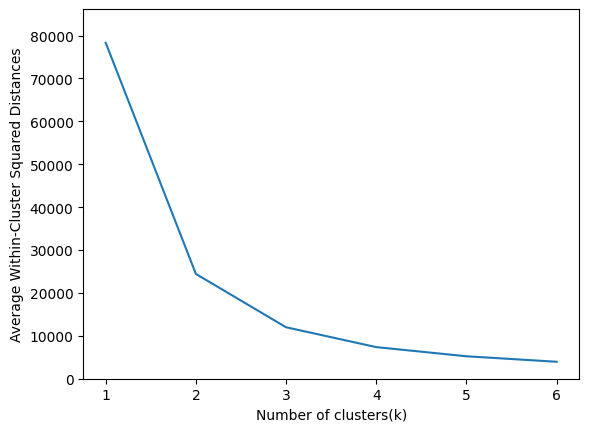

In [ ]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=0).fit(cluster_model1_df)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

### K-Means model

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(cluster_model1_df)
cluster_model1_df['cluster'] = kmeans.labels_
# Cluster membership
memb = pd.Series(kmeans.labels_, index=cluster_model1_df.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  acyclovir, allopurinol, oxycodone hcl/acetaminophen, amlodipine besylate, quetiapine fumarate, bupropion hcl, potassium chloride, escitalopram oxalate, hydroxyzine hcl, spironolactone, pantoprazole sodium, trazodone hcl, ammonium lactate, ropinirole hcl, tamsulosin hcl, metoprolol tartrate, albuterol sulfate, tizanidine hcl, calcitriol, digoxin, metformin hcl, paroxetine hcl, levothyroxine sodium, ibuprofen, ropinirole hcl, pen needle, diabetic, simvastatin, omeprazole, clopidogrel bisulfate, escitalopram oxalate, testosterone cypionate, fluticasone propionate, pramipexole di-hcl, metoprolol tartrate, warfarin sodium, amiodarone hcl, omeprazole, digoxin, potassium chloride, zolpidem tartrate, levetiracetam, hydralazine hcl, gabapentin, furosemide, irbesartan, escitalopram oxalate, quetiapine fumarate, losartan potassium, famotidine, metoprolol tartrate, labetalol hcl, amoxicillin/potassium clav, lorazepam, hydralazine hcl, nifedipine, diltiazem hcl, valsartan, doxycycline monohydr

###  scatter plot

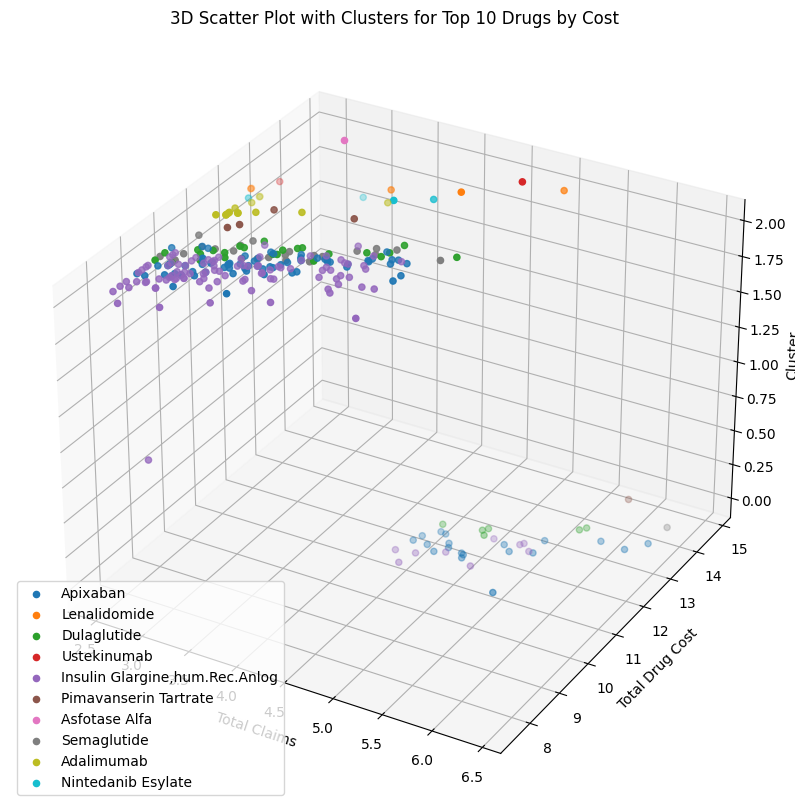

In [ ]:
# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each drug
for drug in top_10_drugs_cost.index:
    drug_data = cluster_model1_df[cluster_model1_df['Gnrc_Name'] == drug]
    ax.scatter(drug_data['Tot_Clms'], drug_data['Tot_Drug_Cst'], drug_data['cluster'], label=drug)

# Labeling axes
ax.set_xlabel('Total Claims')
ax.set_ylabel('Total Drug Cost')
ax.set_zlabel('Cluster')
ax.set_title('3D Scatter Plot with Clusters for Top 10 Drugs by Cost')

# Adding legend for drug names
ax.legend()

plt.show()



In [ ]:
del cluster_drugs_df
del unique_drug_names_per_cluster
del unique_drugs_per_cluster
del drug_in_all_clusters
del count_drug_in_all_clusters
del drug_names_per_cluster

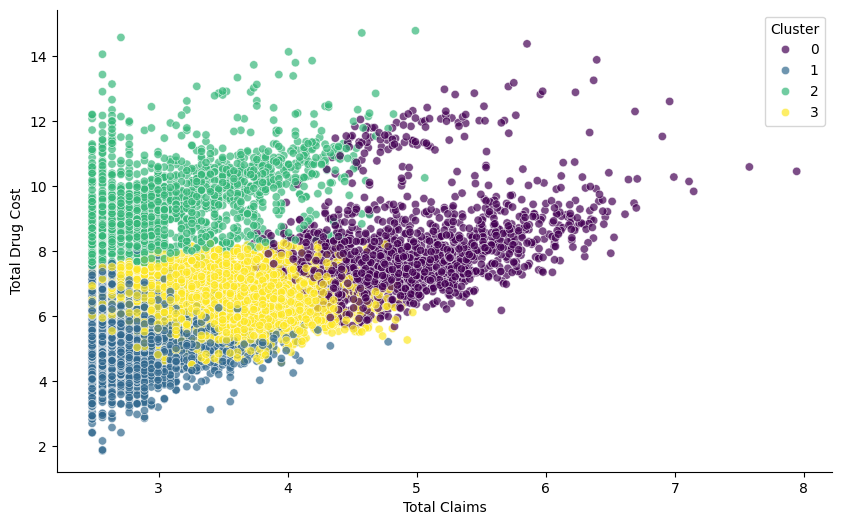

In [ ]:
# Creating a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tot_Clms', y='Tot_Drug_Cst', hue='cluster', data=cluster_model1_df, palette='viridis', alpha=0.7)

# Labeling axes
plt.xlabel('Total Claims', fontsize=10, )
plt.ylabel('Total Drug Cost', fontsize=10)
#plt.title('2D Scatter Plot with Clusters for Top 10 Drugs by Cost')

# Adding legend for cluster names
plt.legend(title='Cluster')
sns.despine()

plt.savefig('scatter_plot.png', bbox_inches='tight')
plt.show()


In [ ]:
cluster_model1_df.columns

Index(['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',
       'cluster'],
      dtype='object')

### Metrics

#### Entropy calculation for clusters

In [ ]:
cluster_model1_df.reset_index(drop=False, inplace=True)
cluster_model1_df.columns

Index(['Gnrc_Name', 'Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',
       'cluster'],
      dtype='object')

In [ ]:
cluster_model1_df.head()

Gnrc_Name  Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
0      potassium chloride     4.700         8.969          8.695      3.497   
1             fluconazole     2.708         4.112          3.296      1.946   
2               acyclovir     4.043         7.444          7.916      2.996   
3  fluticasone/vilanterol     3.091         9.112          6.538      1.946   
4       enalapril maleate     2.639         5.682          6.538      1.946   

   Tot_30day_Fills  Top10Drug  Region_Midwest  Region_Northeast  Region_South  \
0            5.298          0           False             False         False   
1            2.708          0            True             False         False   
2            4.564          0           False             False         False   
3            3.178          0            True             False         False   
4            3.178          0           False             False         False   

   Region_Southeast  Region_Southwest  Region_West  cluster  
0              True             False        False        1  
1             False             False        False        3  
2             False              True        False        0  
3             False             False        False        2  
4              True             False        False        3

In [ ]:
# Group by 'cluster' and count the occurrences of each drug in each cluster
cluster_counts = cluster_model1_df.groupby('cluster')['Gnrc_Name'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_drugs_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 7.4336673941953215
Cluster 1: 6.666233861522514
Cluster 2: 7.177007379187347
Cluster 3: 7.6494490929048045


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


In [ ]:
import math
# Calculate the maximum possible entropy
max_entropy = math.log2(250)

print("Range of entropy values:")
print(f"Minimum entropy: 0")
print(f"Maximum entropy: {max_entropy}")

Range of entropy values:
Minimum entropy: 0
Maximum entropy: 7.965784284662087


#### Entropy for geographic distribution

In [ ]:
# List of region columns
region_columns = ['Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West']

# Initialize an empty DataFrame to store the counts
region_counts_df = pd.DataFrame()

# Iterate over each region column
for region in region_columns:
    # Filter the DataFrame where the region is True
    region_df = cluster_model1_df[cluster_model1_df[region]]
    # Group by 'cluster' and count the occurrences of the region where value is True for each cluster
    cluster_counts = region_df.groupby('cluster').size()
    # Append the counts to the region_counts_df DataFrame with the region name as the column name
    region_counts_df[region] = cluster_counts

# Print the DataFrame
print(region_counts_df)


         Region_Midwest  Region_Northeast  Region_South  Region_Southeast  \
cluster                                                                     
0                   600               718           176               934   
1                   313               307            79               439   
2                   308               362            57               368   
3                   559               673           151               815   

         Region_Southwest  Region_West  
cluster                                 
0                     346          789  
1                     181          264  
2                     167          311  
3                     318          668  


In [ ]:
# Calculate the total count of drugs in each cluster
total_drugs_in_cluster = region_counts_df.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = region_counts_df.div(total_drugs_in_cluster, axis=0)
cluster_probabilities

Region_Midwest  Region_Northeast  Region_South  Region_Southeast  \
cluster                                                                     
0                 0.168             0.202         0.049             0.262   
1                 0.198             0.194         0.050             0.277   
2                 0.196             0.230         0.036             0.234   
3                 0.176             0.211         0.047             0.256   

         Region_Southwest  Region_West  
cluster                                 
0                   0.097        0.221  
1                   0.114        0.167  
2                   0.106        0.198  
3                   0.100        0.210

In [ ]:
#Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities * np.log2(cluster_probabilities)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=1)

# Print the entropy for each cluster
print("Entropy for each Region:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f" {cluster}: {entropy}")

Entropy for each Region:
 0: 2.427537298940374
 1: 2.438928352099746
 2: 2.417994422263554
 3: 2.4310038920214145


### Entropy for disease

In [ ]:
df_impute['cluster_model1']=cluster_model1_df['cluster']

# Group by 'cluster' and count the occurrences of each disease in each cluster
cluster_counts = df_impute.groupby('cluster_model1')['disease'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_disease_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 6.000459829828811
Cluster 1: 5.6096968274348145
Cluster 2: 5.861487864608992
Cluster 3: 6.183136017232037


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


#### Overlap between clusters

In [ ]:
cluster_model1_df.set_index('Gnrc_Name', inplace=True)
cluster_model1_df.columns

Index(['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',
       'cluster'],
      dtype='object')

In [ ]:
cluster_model1_df.reset_index(drop=False, inplace=True)
cluster_model1_df.columns

Index(['Gnrc_Name', 'Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',
       'cluster'],
      dtype='object')

In [ ]:
# Group by cluster and aggregate unique drug names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model1')['Gnrc_Name'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model1')['Gnrc_Name'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 316 unique drugs
acetaminophen with codeine, acetazolamide, acyclovir, albuterol sulfate, alendronate sodium, alfuzosin hcl, allopurinol, alprazolam, amantadine hcl, amiodarone hcl, amitriptyline hcl, amlodipine besylate, amlodipine besylate/benazepril, amlodipine besylate/valsartan, ammonium lactate, amoxicillin, amoxicillin/potassium clav, anastrozole, aripiprazole, atenolol, atenolol/chlorthalidone, atorvastatin calcium, atropine sulfate, azathioprine, azelastine hcl, azithromycin, baclofen, benazepril hcl, benztropine mesylate, betamethasone dipropionate, betamethasone/propylene glyc, bicalutamide, bisoprolol fumarate, bisoprolol/hydrochlorothiazide, brimonidine tartrate, budesonide, bumetanide, bupropion hcl, buspirone hcl, butalb/acetaminophen/caffeine, calcitriol, calcium acetate, carbamazepine, carbidopa/levodopa, carisoprodol, carvedilol, cefadroxil, cefazolin sodium, cefdinir, ceftriaxone sodium, 

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()


Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (185 drugs):
Divalproex Sodium, Pramipexole Di-Hcl, Alendronate Sodium, Finasteride, Nifedipine, Losartan Potassium, Lisinopril/Hydrochlorothiazide, Levothyroxine Sodium, Levetiracetam, Metoprolol Succinate, Ciclopirox, Perphenazine, Zolpidem Tartrate, Nortriptyline Hcl, Glimepiride, Lactulose, Ipratropium Bromide, Atenolol, Hydrocodone/Acetaminophen, Dicyclomine Hcl, Amlodipine Besylate, Anastrozole, Triamterene/Hydrochlorothiazid, Betamethasone/Propylene Glyc, Methocarbamol, Warfarin Sodium, Haloperidol, Methotrexate Sodium, Celecoxib, Lorazepam, Promethazine Hcl, Ranolazine, Amantadine Hcl, Tolterodine Tartrate, Chlorthalidone, Levocetirizine Dihydrochloride, Mupirocin, Famotidine, Fenofibrate, Olanzapine, Betamethasone Valerate, Hydroxyzine Hcl, Pen Needle, Diabetic, Ofloxacin, Albuterol Sulfate, Calcium Acetate, Clopidogrel Bisulfate, Sertraline Hcl, Methylprednisolone, Pioglitazone Hcl, Tamsulosin Hcl

In [ ]:
# Find the drug present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Drug present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")



Drug present in all clusters:
Albuterol Sulfate, Amantadine Hcl, Aripiprazole, Brimonidine Tartrate, Bumetanide, Calcium Acetate, Carbamazepine, Carbidopa/Levodopa, Clobetasol Propionate, Clozapine, Diclofenac Sodium, Diltiazem Hcl, Divalproex Sodium, Doxepin Hcl, Doxycycline Hyclate, Duloxetine Hcl, Esomeprazole Magnesium, Estradiol, Fluticasone Propionate, Hydrocortisone, Insulin Lispro, Ipratropium Bromide, Lamotrigine, Latanoprost, Levetiracetam, Levothyroxine Sodium, Memantine Hcl, Metformin Hcl, Methotrexate Sodium, Mometasone Furoate, Morphine Sulfate, Olanzapine, Oxycodone Hcl, Pantoprazole Sodium, Pen Needle, Diabetic, Pramipexole Di-Hcl, Pregabalin, Quetiapine Fumarate, Ranolazine, Sucralfate, Tolterodine Tartrate, Topiramate, Venlafaxine Hcl, Zolpidem Tartrate
Count: 44


In [ ]:
# Group by cluster and aggregate unique disease names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model1')['disease'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model1')['disease'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 145 unique drugs
abnormal uterine bleeding, acne, actinomycosis, acute coronary syndrome, acute lymphocytic leukemia, acute otitis externa, addison's disease, adhd (attention deficit hyperactivity disorder), aggressive behavior, agitated state, agitation, alcohol dependence, alcohol withdrawal, allergic reactions, allergic rhinitis, allergic urticaria, alopecia, alport syndrome, alzheimer's disease, amenorrhea, amyloidosis, anal itching, androgenetic alopecia, anemia, megaloblastic, anesthetic adjunct, angina, angina pectoris prophylaxis, ankylosing spondylitis, anticholinesterase poisoning, antiphospholipid syndrome, anxiety, anxiety and stress, arrhythmia, aseptic necrosis, asthma, asthma, acute, asthma, maintenance, atherosclerosis, atopic dermatitis, atrial fibrillation, atrophic urethritis, autism, back pain, bacteremia, bacterial endocarditis prevention (bacterial endocarditis prophylaxis), bacterial 

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()


Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (103 drugs):
diabetes, type 2, allergic rhinitis, antiphospholipid syndrome, thalassemia, alzheimer's disease, cogan's syndrome, hypokalemia, tendonitis, pain, chronic pain, underactive thyroid (hypothyroidism), vertigo, hyperthyroidism, asthma, aseptic necrosis, agitated state, arrhythmia, insomnia, diabetic kidney disease (diabetic nephropathy), migraine, polycystic kidney disease, hyperlipoproteinemia type iia, elevated ldl, corneal refractive surgery, aggressive behavior, asthma, maintenance, atrial fibrillation, acute otitis externa, hyperphosphatemia, tinea pedis, erythromelalgia, hyperhidrosis, atherosclerosis, diabetes mellitus, bipolar disorder, seizures (convulsions), diabetes (type 2), acne, urinary incontinence, eye redness, edema, muscle spasm (involuntary hypertonicity), angina pectoris prophylaxis, gingivitis, asthma, acute, constipation, acute, mitral valve prolapse, actinomycosis, atopic de

In [ ]:
# Find the disease present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("disease present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")

disease present in all clusters:
acne, actinomycosis, acute coronary syndrome, adhd (attention deficit hyperactivity disorder), agitated state, agitation, alcohol dependence, alport syndrome, alzheimer's disease, angina, ankylosing spondylitis, anxiety, anxiety and stress, arrhythmia, asthma, asthma, acute, atopic dermatitis, atrial fibrillation, atrophic urethritis, autism, benign prostatic hyperplasia, bipolar disorder, borderline personality disorder, breast cancer, cardiovascular risk reduction, chronic pain, conjunctivitis, conjunctivitis, allergic, conjunctivitis, bacterial, dercum's disease, diabetes mellitus, diabetes, type 1, diabetes, type 2, ectopic pregnancy, edema, generalized anxiety disorder, gerd, glaucoma, open angle, hashimoto's disease (chronic lymphocytic thyroiditis), high blood pressure (hypertension), hyperphosphatemia, insomnia, migraine, mitral valve prolapse, muscle pain, occipital neuralgia, reflex sympathetic dystrophy syndrome, restless legs syndrome, rheum

In [ ]:
cluster_model1_df.reset_index(drop=False, inplace=True)

In [ ]:
cluster_model1_df.columns

Index(['index', 'Gnrc_Name', 'Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply',
       'Tot_Benes', 'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest',
       'Region_Northeast', 'Region_South', 'Region_Southeast',
       'Region_Southwest', 'Region_West', 'cluster'],
      dtype='object')

#### within cluster , between cluster and other

   Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  Tot_30day_Fills  \
0     3.484         6.430          7.353      2.360            4.060   
1     4.945         8.046          8.933      3.738            5.593   
2     3.149         9.559          6.730      2.098            3.444   
3     2.824         5.238          5.877      2.198            3.020   

   Top10Drug  Region_Midwest  Region_Northeast  Region_South  \
0  7.876e-16           0.168             0.200         0.049   
1  2.253e-02           0.196             0.192         0.049   
2  1.530e-01           0.194             0.229         0.036   
3  3.139e-04           0.175             0.211         0.047   

   Region_Southeast  Region_Southwest  Region_West    Cluster  
0             0.261             0.096        0.220  Cluster 0  
1             0.275             0.114        0.165  Cluster 1  
2             0.233             0.106        0.197  Cluster 2  
3             0.255             0.100        0.209  Cluster 3 

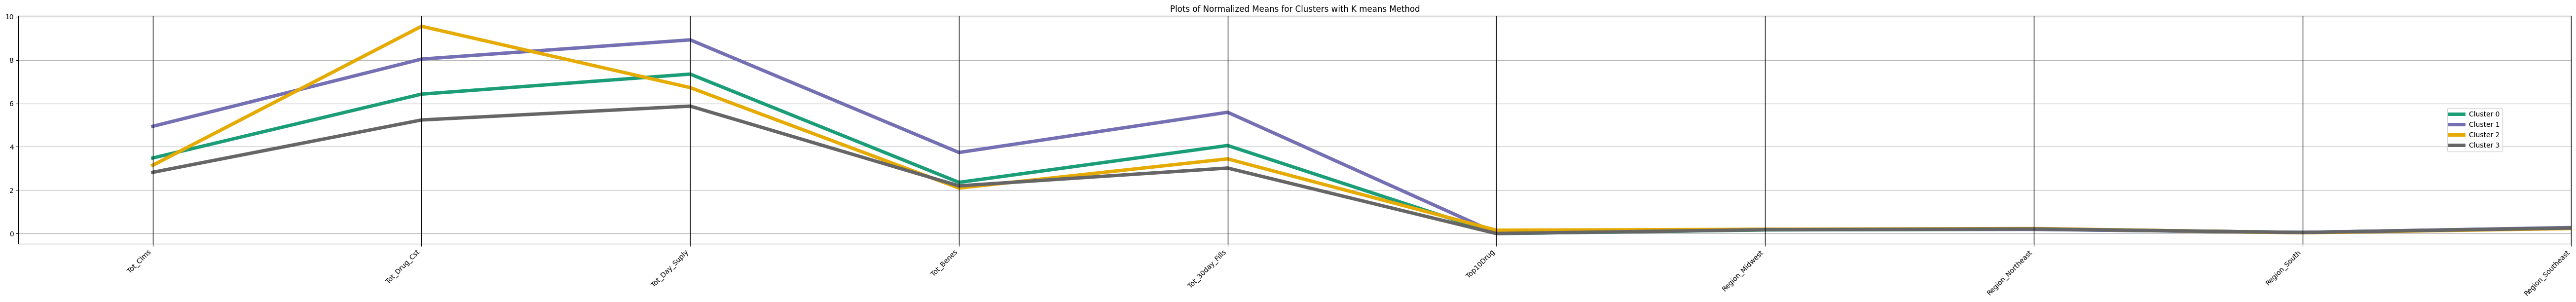

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',])
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals.
centroids['Cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
pd.set_option('display.precision', 3)

#Add 'Cluster number' column
pd.set_option('display.precision', 3)
print(centroids)

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(18,6))
fig = plt.gcf()
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='Cluster',
                          colormap='Dark2', linewidth=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,9)
plt.title('Plots of Normalized Means for Clusters with K means Method')
plt.show()

In [ ]:
centroids.shape

(4, 13)

In [ ]:
withinClusterSS = [0] * 4
clusterCount = [0] * 4
for cluster, distance in zip(kmeans.labels_, kmeans.transform(cluster_model1_df[['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West']])):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1

for cluster, SS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster,
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (3582 members): 8619.15 within cluster
Cluster 1 (1596 members): 6592.15 within cluster
Cluster 2 (1583 members): 5637.20 within cluster
Cluster 3 (3193 members): 8622.01 within cluster


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')))

       0      1      2      3
0  0.000  3.390  3.281  2.268
1  3.390  0.000  4.207  5.542
2  3.281  4.207  0.000  4.441
3  2.268  5.542  4.441  0.000


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')).sum(axis=0))

0     8.940
1    13.140
2    11.929
3    12.251
dtype: float64


In [ ]:
# Add the 'Tot_Drug_Cst' column to cluster_model1_df
cluster_model1_df['Tot_Drug_Cst_new'] = df_impute['Tot_Drug_Cst']

# Calculate average drug cost for each cluster
average_drug_cost_per_cluster = cluster_model1_df.groupby('cluster')['Tot_Drug_Cst_new'].mean()

# Calculate total drug cost for each cluster
total_drug_cost_per_cluster = cluster_model1_df.groupby('cluster')['Tot_Drug_Cst_new'].sum()

# Print the results
print("Average Drug Cost for Each Cluster:")
print(average_drug_cost_per_cluster)

# Print the results
print("Total Drug Cost for Each Cluster:")
print(total_drug_cost_per_cluster)

Average Drug Cost for Each Cluster:
cluster
0      805.372
1    14569.453
2    36685.538
3      274.086
Name: Tot_Drug_Cst_new, dtype: float64
Total Drug Cost for Each Cluster:
cluster
0    2.885e+06
1    2.325e+07
2    5.807e+07
3    8.752e+05
Name: Tot_Drug_Cst_new, dtype: float64


## Model 2 - Top 10 drugs by cost per claim:

1. Identified top 10 drug by calculting cost per claim ratio(Total drug cost / total claims)
2. created new field called 'top10drugr' and identified whether each row belongs to top 10 drug or not(1 or 0)
3. created dummies for region and top10drugr- newly created fields
4. applied log transforamtion on the skewed numerical variables
5. Optimal cluster calculation
6. K- means cluster using numerical variable and newly created variables
7. Calculated the metrics

In [ ]:
# Calculate the cost per claim ratio
df_impute['Cost_Per_Claim'] = df_impute['Tot_Drug_Cst'] / df_impute['Tot_Clms']

# Find the top 10 drugs by cost per claim ratio
top_10_drugs_ratio = df_impute.nlargest(10, 'Cost_Per_Claim')[['Gnrc_Name', 'Cost_Per_Claim']].reset_index(drop=True)
top_10_drugs_ratio = top_10_drugs_ratio.set_index('Gnrc_Name')

# Create a new column 'Top10Drugr' and set it to 0 by default
df_impute['Top10Drugr'] = 0

# Set the 'Top10Drugr' column to 1 for rows where the 'Gnrc_Name' is in the top 10 drugs list
df_impute.loc[df_impute['Gnrc_Name'].isin(top_10_drugs_ratio.index), 'Top10Drugr'] = 1


In [ ]:
# Group by generic name and calculate the total drug cost and total number of claims
generic_name_stats = df_impute.groupby('Gnrc_Name').agg({'Tot_Drug_Cst': 'sum', 'Tot_Clms': 'sum'})

# Calculate the cost per claim for each generic name
generic_name_stats['Cost_Per_Claim'] = generic_name_stats['Tot_Drug_Cst'] / generic_name_stats['Tot_Clms']

# Sort the generic names based on the calculated cost per claim
top_10_generic_names = generic_name_stats.sort_values(by='Cost_Per_Claim').tail(10)

# Print the top 10 generic names with the high cost per claim
print("Top 10 Generic Names with highest Cost Per Claim:")
print(top_10_generic_names)

Top 10 Generic Names with highest Cost Per Claim:
                                Tot_Drug_Cst  Tot_Clms  Cost_Per_Claim
Gnrc_Name                                                             
lenalidomide                       4.674e+06       269       17376.276
immune globul g/gly/iga avg 46     4.737e+05        26       18218.549
pomalidomide                       9.175e+05        41       22376.898
ustekinumab                        2.761e+06       109       25332.041
elexacaftor/tezacaftor/ivacaft     1.369e+06        54       25357.246
vigabatrin                         4.019e+05        12       33491.380
midostaurin                        5.082e+05        13       39094.416
eculizumab                         6.800e+05        12       56666.060
golodirsen                         1.270e+06        12      105858.193
asfotase alfa                      2.129e+06        14      152037.600


In [ ]:
top_10_drugs_ratio

Cost_Per_Claim
Gnrc_Name                                     
asfotase alfa                       152037.600
golodirsen                          105858.193
eculizumab                           56666.060
midostaurin                          39094.416
vigabatrin                           33491.380
ustekinumab                          25491.594
elexacaftor/tezacaftor/ivacaft       25357.246
ustekinumab                          24153.801
pomalidomide                         22376.898
immune globul g/gly/iga avg 46       18218.549

### Create dummies

In [ ]:
del cluster_model2_df

NameError: name 'cluster_model2_df' is not defined

In [ ]:
cluster_model2_df = pd.get_dummies(df_impute[['Region','Top10Drugr']],drop_first=False)
cluster_model2_df = pd.concat([df_impute[['Gnrc_Name','Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes','Tot_30day_Fills']],
                               cluster_model2_df], axis=1)
cluster_model2_df.set_index('Gnrc_Name', inplace=True)

In [ ]:
cluster_model2_df.shape

(9954, 12)

### Normalize the data columns

In [ ]:
# Define the columns to apply log transformation
columns_to_transform = ['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes', 'Tot_30day_Fills']

# Apply log transformation to the selected columns
for column in columns_to_transform:
    cluster_model2_df[column] = np.log(cluster_model2_df[column] + 1)  # Adding 1 to handle zero values

cluster_model2_df.head()

Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
Gnrc_Name                                                                  
potassium chloride         4.700         8.969          8.695      3.497   
fluconazole                2.708         4.112          3.296      1.946   
acyclovir                  4.043         7.444          7.916      2.996   
fluticasone/vilanterol     3.091         9.112          6.538      1.946   
enalapril maleate          2.639         5.682          6.538      1.946   

                        Tot_30day_Fills  ...  Region_Northeast  Region_South  \
Gnrc_Name                                ...                                   
potassium chloride                5.298  ...             False         False   
fluconazole                       2.708  ...             False         False   
acyclovir                         4.564  ...             False         False   
fluticasone/vilanterol            3.178  ...             False         False   
enalapril maleate                 3.178  ...             False         False   

                        Region_Southeast  Region_Southwest  Region_West  
Gnrc_Name                                                                
potassium chloride                  True             False        False  
fluconazole                        False             False        False  
acyclovir                          False              True        False  
fluticasone/vilanterol             False             False        False  
enalapril maleate                   True             False        False  

[5 rows x 12 columns]

### Optimal number of clusters

In [ ]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=0).fit(cluster_model2_df)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

### K means model

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(cluster_model2_df)
cluster_model2_df['cluster'] = kmeans.labels_
# Cluster membership
memb = pd.Series(kmeans.labels_, index=cluster_model2_df.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  acyclovir, allopurinol, oxycodone hcl/acetaminophen, amlodipine besylate, quetiapine fumarate, bupropion hcl, potassium chloride, escitalopram oxalate, hydroxyzine hcl, spironolactone, pantoprazole sodium, trazodone hcl, ammonium lactate, ropinirole hcl, tamsulosin hcl, metoprolol tartrate, albuterol sulfate, tizanidine hcl, calcitriol, digoxin, metformin hcl, paroxetine hcl, levothyroxine sodium, ibuprofen, ropinirole hcl, pen needle, diabetic, simvastatin, omeprazole, clopidogrel bisulfate, escitalopram oxalate, testosterone cypionate, fluticasone propionate, pramipexole di-hcl, metoprolol tartrate, warfarin sodium, amiodarone hcl, omeprazole, digoxin, potassium chloride, zolpidem tartrate, levetiracetam, hydralazine hcl, gabapentin, furosemide, irbesartan, escitalopram oxalate, quetiapine fumarate, losartan potassium, famotidine, metoprolol tartrate, labetalol hcl, amoxicillin/potassium clav, lorazepam, hydralazine hcl, nifedipine, diltiazem hcl, valsartan, doxycycline monohydr

### Scatter plot

In [ ]:
cluster_model2_df.reset_index(drop=False, inplace=True)

In [ ]:
# Creating a 3D scatter plot
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each drug
for drug in top_10_drugs_cost.index:
    drug_data = cluster_model2_df[cluster_model2_df['Gnrc_Name'] == drug]
    ax.scatter(drug_data['Tot_Clms'], drug_data['Tot_Drug_Cst'], drug_data['cluster'], label=drug)

# Labeling axes
ax.set_xlabel('Total Claims')
ax.set_ylabel('Total Drug Cost')
ax.set_zlabel('Cluster')
ax.set_title('3D Scatter Plot with Clusters for Top 10 Drugs by Cost')

# Adding legend for drug names
ax.legend()

plt.show()

In [ ]:
# Creating a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tot_Clms', y='Tot_Drug_Cst', hue='cluster', data=cluster_model2_df, palette='viridis', alpha=0.7)

# Labeling axes
plt.xlabel('Total Claims')
plt.ylabel('Total Drug Cost')
plt.title('2D Scatter Plot with Clusters for Top 10 Drugs by Cost per claim ratio')

# Adding legend for cluster names
plt.legend(title='Cluster')

plt.show()


### Metrics

#### Entropy calculation

In [ ]:
cluster_model2_df.reset_index(drop=False, inplace=True)
cluster_model1_df.columns

Index(['index', 'Gnrc_Name', 'Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply',
       'Tot_Benes', 'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest',
       'Region_Northeast', 'Region_South', 'Region_Southeast',
       'Region_Southwest', 'Region_West', 'cluster', 'Tot_Drug_Cst_new'],
      dtype='object')

In [ ]:
# Group by 'cluster' and count the occurrences of each drug in each cluster
cluster_counts = cluster_model2_df.groupby('cluster')['Gnrc_Name'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_drugs_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 7.4336412403131655
Cluster 1: 6.66782981105602
Cluster 2: 7.650355912054411
Cluster 3: 7.180953365975036


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


#### Entropy for geographic distribution

In [ ]:
# List of region columns
region_columns = ['Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West']

# Initialize an empty DataFrame to store the counts
region_counts_df = pd.DataFrame()

# Iterate over each region column
for region in region_columns:
    # Filter the DataFrame where the region is True
    region_df = cluster_model2_df[cluster_model2_df[region]]
    # Group by 'cluster' and count the occurrences of the region where value is True for each cluster
    cluster_counts = region_df.groupby('cluster').size()
    # Append the counts to the region_counts_df DataFrame with the region name as the column name
    region_counts_df[region] = cluster_counts

# Calculate the total count of drugs in each cluster
total_drugs_in_cluster = region_counts_df.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = region_counts_df.div(total_drugs_in_cluster, axis=0)

#Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities * np.log2(cluster_probabilities)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=1)

# Print the entropy for each cluster
print("Entropy for each Region:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f" {cluster}: {entropy}")


Entropy for each Region:
 0: 2.4275082410558464
 1: 2.438617545226758
 2: 2.431036511905181
 3: 2.4182485704901353


#### Entropy for disease

In [ ]:
df_impute['cluster_model2']=cluster_model2_df['cluster']

# Group by 'cluster' and count the occurrences of each disease in each cluster
cluster_counts = df_impute.groupby('cluster_model2')['disease'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_disease_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 6.000727329353292
Cluster 1: 5.611323430156878
Cluster 2: 6.183640510966942
Cluster 3: 5.864718540771014


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


#### Overlap between clusters

In [ ]:
# Group by cluster and aggregate unique drug names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model2')['Gnrc_Name'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model2')['Gnrc_Name'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 316 unique drugs
acetaminophen with codeine, acetazolamide, acyclovir, albuterol sulfate, alendronate sodium, alfuzosin hcl, allopurinol, alprazolam, amantadine hcl, amiodarone hcl, amitriptyline hcl, amlodipine besylate, amlodipine besylate/benazepril, amlodipine besylate/valsartan, ammonium lactate, amoxicillin, amoxicillin/potassium clav, anastrozole, aripiprazole, atenolol, atenolol/chlorthalidone, atorvastatin calcium, atropine sulfate, azathioprine, azelastine hcl, azithromycin, baclofen, benazepril hcl, benztropine mesylate, betamethasone dipropionate, betamethasone/propylene glyc, bicalutamide, bisoprolol fumarate, bisoprolol/hydrochlorothiazide, brimonidine tartrate, budesonide, bumetanide, bupropion hcl, buspirone hcl, butalb/acetaminophen/caffeine, calcitriol, calcium acetate, carbamazepine, carbidopa/levodopa, carisoprodol, carvedilol, cefadroxil, cefazolin sodium, cefdinir, ceftriaxone sodium, 

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()


Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (181 drugs):
gatifloxacin, levetiracetam, levothyroxine sodium, hydrocortisone, hydrocodone/acetaminophen, letrozole, fenofibrate, donepezil hcl, tolterodine tartrate, doxepin hcl, divalproex sodium, benztropine mesylate, spironolactone, betamethasone dipropionate, quetiapine fumarate, fludrocortisone acetate, clindamycin phosphate, pramipexole di-hcl, methylprednisolone, tamsulosin hcl, esomeprazole magnesium, alprazolam, latanoprost, famotidine, gabapentin, hydroxychloroquine sulfate, methotrexate sodium, amantadine hcl, labetalol hcl, finasteride, primidone, clozapine, liothyronine sodium, repaglinide, metoprolol succinate, fluticasone propionate, nortriptyline hcl, digoxin, mupirocin, carbamazepine, flecainide acetate, oxybutynin chloride, simvastatin, warfarin sodium, lorazepam, oxycodone hcl/acetaminophen, aripiprazole, potassium chloride, albuterol sulfate, glipizide, baclofen, diclofenac sodium, mel

In [ ]:
# Find the drug present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Drug present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")



Drug present in all clusters:
albuterol sulfate, amantadine hcl, aripiprazole, brimonidine tartrate, bumetanide, calcium acetate, carbamazepine, carbidopa/levodopa, clobetasol propionate, clozapine, diclofenac sodium, diltiazem hcl, divalproex sodium, doxepin hcl, doxycycline hyclate, duloxetine hcl, esomeprazole magnesium, estradiol, fluticasone propionate, hydrocortisone, insulin lispro, ipratropium bromide, lamotrigine, latanoprost, levetiracetam, levothyroxine sodium, memantine hcl, metformin hcl, methotrexate sodium, mometasone furoate, morphine sulfate, olanzapine, oxycodone hcl, pantoprazole sodium, pen needle, diabetic, pramipexole di-hcl, pregabalin, quetiapine fumarate, ranolazine, sucralfate, tolterodine tartrate, topiramate, venlafaxine hcl, ziprasidone hcl, zolpidem tartrate
Count: 45


In [ ]:
# Group by cluster and aggregate unique drug names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model2')['disease'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model2')['disease'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique disease names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique disease")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique disease names:
Cluster 0: 145 unique disease
abnormal uterine bleeding, acne, actinomycosis, acute coronary syndrome, acute lymphocytic leukemia, acute otitis externa, addison's disease, adhd (attention deficit hyperactivity disorder), aggressive behavior, agitated state, agitation, alcohol dependence, alcohol withdrawal, allergic reactions, allergic rhinitis, allergic urticaria, alopecia, alport syndrome, alzheimer's disease, amenorrhea, amyloidosis, anal itching, androgenetic alopecia, anemia, megaloblastic, anesthetic adjunct, angina, angina pectoris prophylaxis, ankylosing spondylitis, anticholinesterase poisoning, antiphospholipid syndrome, anxiety, anxiety and stress, arrhythmia, aseptic necrosis, asthma, asthma, acute, asthma, maintenance, atherosclerosis, atopic dermatitis, atrial fibrillation, atrophic urethritis, autism, back pain, bacteremia, bacterial endocarditis prevention (bacterial endocarditis prophylaxis), bacte

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()

Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (103 drugs):
diabetes, type 2, allergic rhinitis, antiphospholipid syndrome, thalassemia, alzheimer's disease, cogan's syndrome, hypokalemia, tendonitis, pain, chronic pain, underactive thyroid (hypothyroidism), vertigo, hyperthyroidism, asthma, aseptic necrosis, agitated state, arrhythmia, insomnia, diabetic kidney disease (diabetic nephropathy), migraine, polycystic kidney disease, hyperlipoproteinemia type iia, elevated ldl, corneal refractive surgery, aggressive behavior, asthma, maintenance, atrial fibrillation, acute otitis externa, hyperphosphatemia, tinea pedis, erythromelalgia, hyperhidrosis, atherosclerosis, diabetes mellitus, bipolar disorder, seizures (convulsions), diabetes (type 2), acne, urinary incontinence, eye redness, edema, muscle spasm (involuntary hypertonicity), angina pectoris prophylaxis, gingivitis, asthma, acute, constipation, acute, mitral valve prolapse, actinomycosis, atopic de

In [ ]:
# Find the disease present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Disease present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")



Disease present in all clusters:
acne, actinomycosis, acute coronary syndrome, adhd (attention deficit hyperactivity disorder), agitated state, agitation, alcohol dependence, alport syndrome, alzheimer's disease, angina, ankylosing spondylitis, anxiety, anxiety and stress, arrhythmia, asthma, asthma, acute, atopic dermatitis, atrial fibrillation, atrophic urethritis, autism, benign prostatic hyperplasia, bipolar disorder, borderline personality disorder, breast cancer, cardiovascular risk reduction, chronic pain, conjunctivitis, conjunctivitis, allergic, conjunctivitis, bacterial, dercum's disease, diabetes mellitus, diabetes, type 1, diabetes, type 2, ectopic pregnancy, edema, generalized anxiety disorder, gerd, glaucoma, open angle, hashimoto's disease (chronic lymphocytic thyroiditis), high blood pressure (hypertension), hyperphosphatemia, insomnia, migraine, mitral valve prolapse, muscle pain, occipital neuralgia, reflex sympathetic dystrophy syndrome, restless legs syndrome, rheum

check to sort alpha the cluster result - overlap between generic  each cluster - could be used as a metric

   Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  Tot_30day_Fills  \
0     3.484         6.431          7.353      2.360            4.061   
1     4.945         8.051          8.932      3.738            5.592   
2     2.823         5.241          5.879      2.197            3.021   
3     3.151         9.569          6.731      2.098            3.445   

   Top10Drugr  Region_Midwest  Region_Northeast  Region_South  \
0   4.836e-17           0.167             0.200         0.050   
1  -6.505e-19           0.196             0.193         0.049   
2   4.098e-17           0.175             0.211         0.047   
3   6.234e-03           0.193             0.231         0.037   

   Region_Southeast  Region_Southwest  Region_West    Cluster  
0             0.261             0.096        0.220  Cluster 0  
1             0.275             0.114        0.165  Cluster 1  
2             0.255             0.099        0.209  Cluster 2  
3             0.231             0.107        0.195  Clust

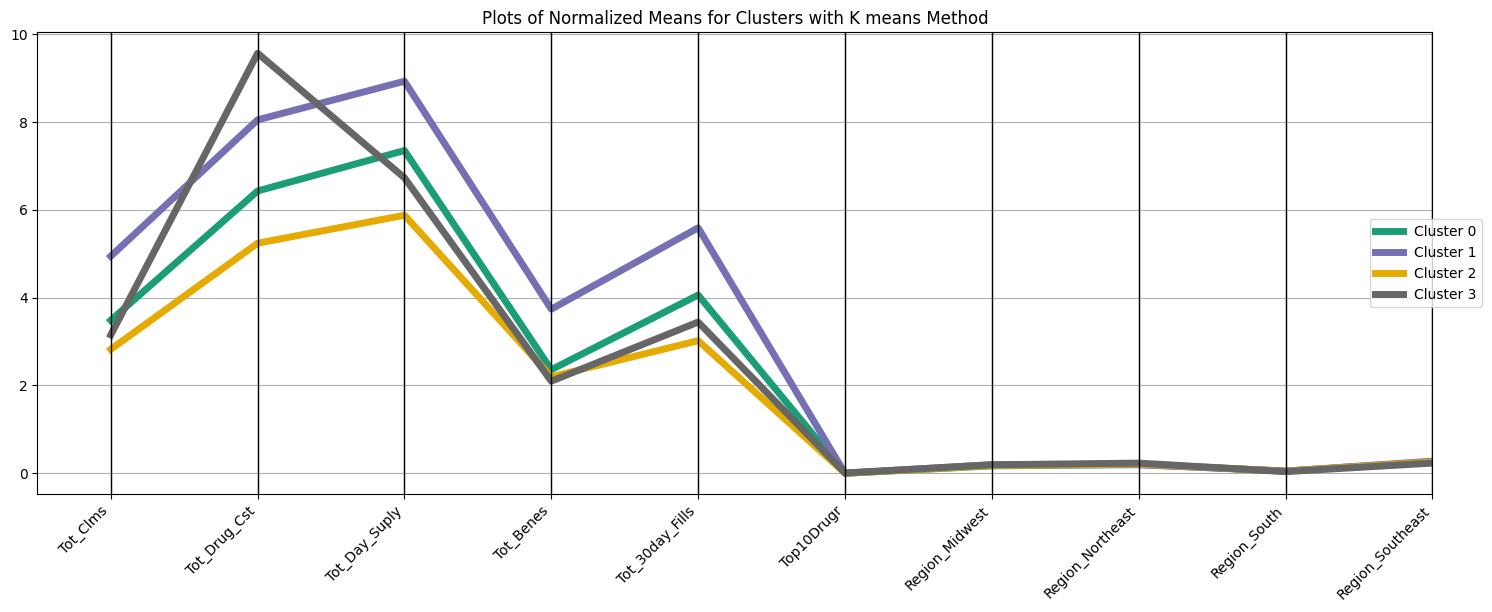

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drugr', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West'])
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals.
centroids['Cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
pd.set_option('display.precision', 3)

#Add 'Cluster number' column
pd.set_option('display.precision', 3)
print(centroids)

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(18,6))
#fig = plt.gcf()
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='Cluster',
                          colormap='Dark2', linewidth=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,9)
plt.title('Plots of Normalized Means for Clusters with K means Method')
plt.show()

In [ ]:
withinClusterSS = [0] * 4
clusterCount = [0] * 4
for cluster, distance in zip(kmeans.labels_, kmeans.transform(cluster_model2_df[['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drugr', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West']])):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1

for cluster, SS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster,
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (3583 members): 8625.19 within cluster
Cluster 1 (1596 members): 6561.82 within cluster
Cluster 2 (3194 members): 8626.37 within cluster
Cluster 3 (1581 members): 5425.72 within cluster


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')))

       0      1      2      3
0  0.000  3.392  2.269  3.278
1  3.392  0.000  5.544  4.205
2  2.269  5.544  0.000  4.437
3  3.278  4.205  4.437  0.000


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')).sum(axis=0))

0     8.939
1    13.141
2    12.250
3    11.920
dtype: float64


In [ ]:
# Add the 'Tot_Drug_Cst' column to cluster_model1_df
cluster_model2_df['Tot_Drug_Cst_new'] = df_impute['Tot_Drug_Cst']

# Calculate average drug cost for each cluster
average_drug_cost_per_cluster = cluster_model2_df.groupby('cluster')['Tot_Drug_Cst_new'].mean()

# Calculate total drug cost for each cluster
total_drug_cost_per_cluster = cluster_model2_df.groupby('cluster')['Tot_Drug_Cst_new'].sum()

# Print the results
print("Average Drug Cost for Each Cluster:")
print(average_drug_cost_per_cluster)

# Print the results
print("Total Drug Cost for Each Cluster:")
print(total_drug_cost_per_cluster)

Average Drug Cost for Each Cluster:
cluster
0      805.320
1    14595.814
2      274.731
3    36703.467
Name: Tot_Drug_Cst_new, dtype: float64
Total Drug Cost for Each Cluster:
cluster
0    2.885e+06
1    2.329e+07
2    8.775e+05
3    5.803e+07
Name: Tot_Drug_Cst_new, dtype: float64


## Model 3 - Top 10 drugs by cost per claim:

1. Identified top 10 drug by calculting cost per claim ratio(Total drug cost / total claims)
2. created new field called 'top10drugr' and identified whether each row belongs to top 10 drug or not(1 or 0)
3. created dummies for region and top10drugr- newly created fields
4. applied Robust transforamtion on the skewed numerical variables
5. Optimal cluster calculation
6. K- means cluster using numerical variable and newly created variables
7. Calculated the metrics

In [ ]:
 del cluster_model3_df

NameError: name 'cluster_model3_df' is not defined

In [ ]:
# Calculate the cost per claim ratio
df_impute['Cost_Per_Claim'] = df_impute['Tot_Drug_Cst'] / df_impute['Tot_Clms']

# Find the top 10 drugs by cost per claim ratio
top_10_drugs_ratio = df_impute.nlargest(10, 'Cost_Per_Claim')[['Gnrc_Name', 'Cost_Per_Claim']].reset_index(drop=True)
top_10_drugs_ratio = top_10_drugs_ratio.set_index('Gnrc_Name')

# Create a new column 'Top10Drugr' and set it to 0 by default
df_impute['Top10Drugr'] = 0

# Set the 'Top10Drugr' column to 1 for rows where the 'Gnrc_Name' is in the top 10 drugs list
df_impute.loc[df_impute['Gnrc_Name'].isin(top_10_drugs_ratio.index), 'Top10Drugr'] = 1


### Create dummies

In [ ]:
del cluster_model3_df

In [ ]:
cluster_model3_df = pd.get_dummies(df_impute[['Region','Top10Drugr']],drop_first=False,dtype=bool)
cluster_model3_df = pd.concat([df_impute[['Gnrc_Name','Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes','Tot_30day_Fills']],
                               cluster_model3_df], axis=1)
cluster_model3_df.set_index('Gnrc_Name', inplace=True)

In [ ]:
cluster_model3_df.head()

Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
Gnrc_Name                                                                  
potassium chloride           109       7852.12           5970         32   
fluconazole                   14         60.08             26          6   
acyclovir                     56       1708.94           2740         19   
fluticasone/vilanterol        21       9058.23            690          6   
enalapril maleate             13        292.68            690          6   

                        Tot_30day_Fills  Top10Drugr  Region_Midwest  \
Gnrc_Name                                                             
potassium chloride                199.0           0           False   
fluconazole                        14.0           0            True   
acyclovir                          95.0           0           False   
fluticasone/vilanterol             23.0           0            True   
enalapril maleate                  23.0           0           False   

                        Region_Northeast  Region_South  Region_Southeast  \
Gnrc_Name                                                                  
potassium chloride                 False         False              True   
fluconazole                        False         False             False   
acyclovir                          False         False             False   
fluticasone/vilanterol             False         False             False   
enalapril maleate                  False         False              True   

                        Region_Southwest  Region_West  
Gnrc_Name                                              
potassium chloride                 False        False  
fluconazole                        False        False  
acyclovir                           True        False  
fluticasone/vilanterol             False        False  
enalapril maleate                  False        False

### Normalize the data columns

y robust ?

In [ ]:
# Define the columns to apply log transformation
columns_to_transform = ['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes', 'Tot_30day_Fills']

# Apply log transformation to the selected columns
for column in columns_to_transform:
    cluster_model3_df[column] = np.log(cluster_model3_df[column] + 1)  # Adding 1 to handle zero values

# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform the data
cluster_model3_df= pd.DataFrame(scaler.fit_transform(cluster_model3_df),
                                        columns=cluster_model3_df.columns,
                                        index=cluster_model3_df.index)

# Display the first few rows of the scaled DataFrame
print(cluster_model3_df.head(1))


                    Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
Gnrc_Name                                                              
potassium chloride     1.278         1.116          1.084      1.642   

                    Tot_30day_Fills  Top10Drugr  Region_Midwest  \
Gnrc_Name                                                         
potassium chloride            1.166         0.0             0.0   

                    Region_Northeast  Region_South  Region_Southeast  \
Gnrc_Name                                                              
potassium chloride               0.0           0.0               1.0   

                    Region_Southwest  Region_West  
Gnrc_Name                                          
potassium chloride               0.0          0.0  


### Optimal number of clusters

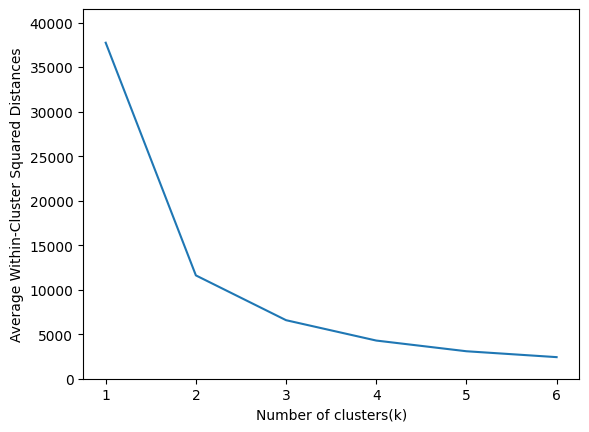

In [ ]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=0).fit(cluster_model3_df)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

### K means model

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(cluster_model3_df)
cluster_model3_df['cluster'] = kmeans.labels_
# Cluster membership
memb = pd.Series(kmeans.labels_, index=cluster_model3_df.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  fluticasone/vilanterol, cevimeline hcl, insulin glargine,hum.rec.anlog, dolutegravir/rilpivirine, cariprazine hcl, fluticasone propion/salmeterol, calcitriol, insulin aspart, fluticasone/umeclidin/vilanter, perampanel, milnacipran hcl, rivaroxaban, insulin glargine,hum.rec.anlog, fluticasone propion/salmeterol, sitagliptin phosphate, enoxaparin sodium, bimatoprost, dextroamphetamine/amphetamine, brimonidine tartrate/timolol, lurasidone hcl, quetiapine fumarate, aripiprazole, ospemifene, nifedipine, budesonide/formoterol fumarate, trospium chloride, evolocumab, amantadine hcl, sitagliptin phos/metformin hcl, vortioxetine hydrobromide, ipratropium bromide, tiotropium bromide, beclomethasone dipropionate, mesalamine, insulin glargine,hum.rec.anlog, sitagliptin phosphate, empagliflozin, insulin pump cart,cont inf,bt, insulin glargine,hum.rec.anlog, epoetin alfa, budesonide/formoterol fumarate, apixaban, cyclosporine, oxycodone myristate, insulin detemir, darunavir/cob/emtri/tenof alaf

### Scatter plot

In [ ]:
cluster_model3_df.reset_index(drop=False, inplace=True)

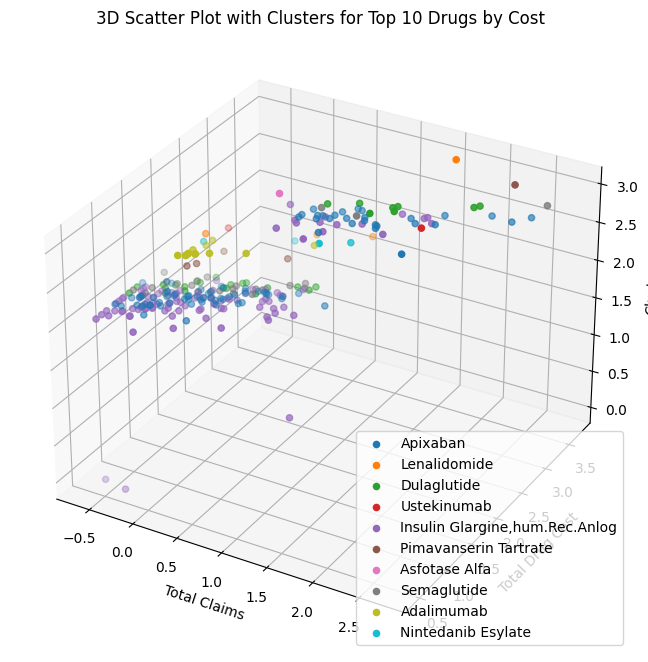

In [ ]:
# Creating a 3D scatter plot
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each drug
for drug in top_10_drugs_cost.index:
    drug_data = cluster_model3_df[cluster_model3_df['Gnrc_Name'] == drug]
    ax.scatter(drug_data['Tot_Clms'], drug_data['Tot_Drug_Cst'], drug_data['cluster'], label=drug)

# Labeling axes
ax.set_xlabel('Total Claims')
ax.set_ylabel('Total Drug Cost')
ax.set_zlabel('Cluster')
ax.set_title('3D Scatter Plot with Clusters for Top 10 Drugs by Cost')

# Adding legend for drug names
ax.legend()

plt.show()

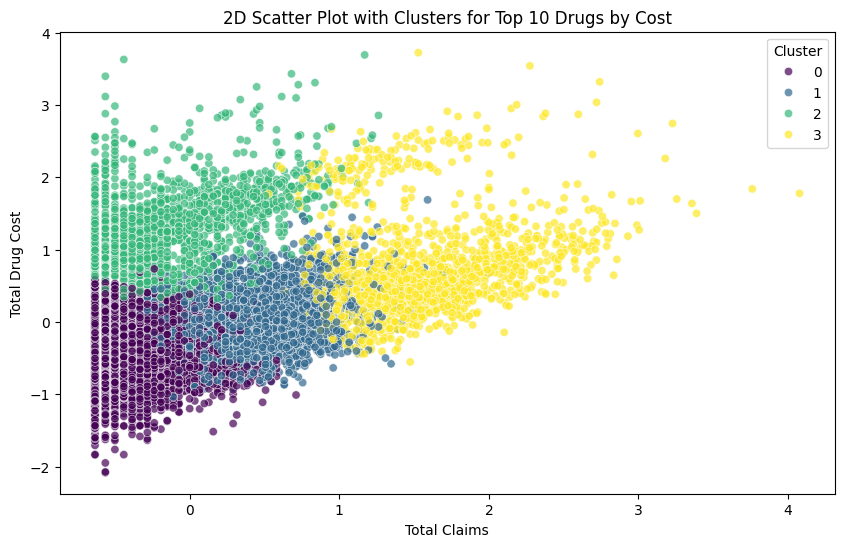

In [ ]:
# Creating a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tot_Clms', y='Tot_Drug_Cst', hue='cluster', data=cluster_model3_df, palette='viridis', alpha=0.7)

# Labeling axes
plt.xlabel('Total Claims')
plt.ylabel('Total Drug Cost')
plt.title('2D Scatter Plot with Clusters for Top 10 Drugs by Cost')

# Adding legend for cluster names
plt.legend(title='Cluster')

plt.show()


### Metrics

#### Entropy calculation

In [ ]:
cluster_model3_df.reset_index(drop=False, inplace=True)
cluster_model3_df.head()

Gnrc_Name  Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
0      potassium chloride     1.278         1.116          1.084      1.642   
1             fluconazole    -0.441        -1.080         -2.340      0.000   
2               acyclovir     0.711         0.427          0.590      1.112   
3  fluticasone/vilanterol    -0.110         1.180         -0.284      0.000   
4       enalapril maleate    -0.500        -0.370         -0.284      0.000   

   Tot_30day_Fills  Top10Drugr  Region_Midwest  Region_Northeast  \
0            1.166         0.0             0.0               0.0   
1           -0.734         0.0             1.0               0.0   
2            0.628         0.0             0.0               0.0   
3           -0.389         0.0             1.0               0.0   
4           -0.389         0.0             0.0               0.0   

   Region_South  Region_Southeast  Region_Southwest  Region_West  cluster  
0           0.0               1.0               0.0          0.0        1  
1           0.0               0.0               0.0          0.0        2  
2           0.0               0.0               1.0          0.0        3  
3           0.0               0.0               0.0          0.0        0  
4           0.0               1.0               0.0          0.0        2

In [ ]:
# Group by 'cluster' and count the occurrences of each drug in each cluster
cluster_counts = cluster_model3_df.groupby('cluster')['Gnrc_Name'].value_counts().unstack(fill_value=0)

# Transpose the DataFrame to have clusters and counts as columns and drugs as rows
cluster_counts_transposed = cluster_counts.T

# Group by 'cluster' and count the occurrences of each drug in each cluster
cluster_counts = cluster_model3_df.groupby('cluster')['Gnrc_Name'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_drugs_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 7.355359935037276
Cluster 1: 6.686695292606329
Cluster 2: 7.819829580331139
Cluster 3: 7.235873959401205


#### Entropy for geographic distribution

In [ ]:
# List of region columns
region_columns = ['Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West']

# Initialize an empty DataFrame to store the counts
region_counts_df = pd.DataFrame()

# Iterate over each region column
for region in region_columns:
    # Filter the DataFrame where the region is True
    region_df = cluster_model3_df[cluster_model3_df[region]==1]
    # Group by 'cluster' and count the occurrences of the region where value is True for each cluster
    cluster_counts = region_df.groupby('cluster').size()
    # Append the counts to the region_counts_df DataFrame with the region name as the column name
    region_counts_df[region] = cluster_counts

# Calculate the total count of drugs in each cluster
total_drugs_in_cluster = region_counts_df.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = region_counts_df.div(total_drugs_in_cluster, axis=0)

#Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities * np.log2(cluster_probabilities)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=1)

# Print the entropy for each cluster
print("Entropy for each Region:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f" {cluster}: {entropy}")


Entropy for each Region:
 0: 2.430931903675819
 1: 2.43628749069282
 2: 2.421108359832421
 3: 2.431863400926165


#### Entropy for disease

In [ ]:
df_impute['cluster_model3']=cluster_model3_df['cluster']

# Group by 'cluster' and count the occurrences of each disease in each cluster
cluster_counts = df_impute.groupby('cluster_model3')['disease'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_disease_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 5.975507363054002
Cluster 1: 5.659115670517757
Cluster 2: 6.291924862906209
Cluster 3: 5.8419844409518324


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


#### Overlap between clusters

   Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  Tot_30day_Fills  \
0    -0.112         1.313         -0.190      0.098           -0.232   
1     1.533         0.741          1.235      1.995            1.404   
2    -0.323        -0.459         -0.558      0.199           -0.422   
3     0.440         0.023          0.379      0.626            0.436   

   Top10Drugr  Region_Midwest  Region_Northeast  Region_South  \
0   6.321e-03           0.199             0.224         0.039   
1   9.107e-18           0.202             0.192         0.048   
2  -2.233e-17           0.178             0.213         0.044   
3  -8.240e-18           0.156             0.197         0.053   

   Region_Southeast  Region_Southwest  Region_West    Cluster  
0             0.228             0.109        0.195  Cluster 0  
1             0.273             0.113        0.162  Cluster 1  
2             0.253             0.096        0.214  Cluster 2  
3             0.270             0.100        0.218  Clust

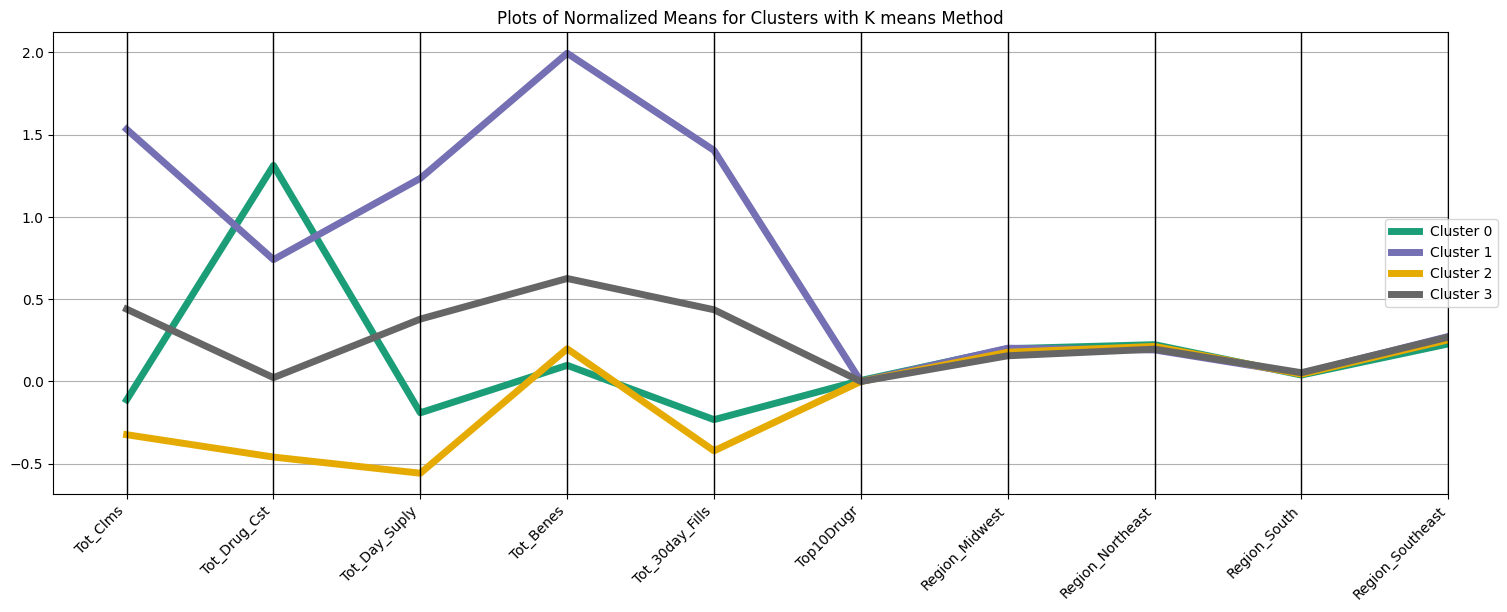

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drugr', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West'])
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals.
centroids['Cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
pd.set_option('display.precision', 3)

#Add 'Cluster number' column
pd.set_option('display.precision', 3)
print(centroids)

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(18,6))
#fig = plt.gcf()
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='Cluster',
                          colormap='Dark2', linewidth=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,9)
plt.title('Plots of Normalized Means for Clusters with K means Method')
plt.show()

In [ ]:
centroids.columns

Index(['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drugr', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',
       'Cluster'],
      dtype='object')

In [ ]:
withinClusterSS = [0] * 4
clusterCount = [0] * 4
for cluster, distance in zip(kmeans.labels_, kmeans.transform(cluster_model3_df[['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drugr', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West']])):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1

for cluster, SS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster,
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (1582 members): 2652.67 within cluster
Cluster 1 (1515 members): 3490.94 within cluster
Cluster 2 (4114 members): 6604.05 within cluster
Cluster 3 (2743 members): 4401.63 within cluster


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')))

       0      1      2      3
0  0.000  3.368  1.836  1.739
1  3.368  0.000  3.830  2.293
2  1.836  3.830  0.000  1.616
3  1.739  2.293  1.616  0.000


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')).sum(axis=0))

0    6.943
1    9.491
2    7.282
3    5.648
dtype: float64


In [ ]:
# Add the 'Tot_Drug_Cst' column to cluster_model1_df
cluster_model3_df['Tot_Drug_Cst_new'] = df_impute['Tot_Drug_Cst']

# Calculate average drug cost for each cluster
average_drug_cost_per_cluster = cluster_model3_df.groupby('cluster')['Tot_Drug_Cst_new'].mean()

# Calculate total drug cost for each cluster
total_drug_cost_per_cluster = cluster_model3_df.groupby('cluster')['Tot_Drug_Cst_new'].sum()

# Print the results
print("Average Drug Cost for Each Cluster:")
print(average_drug_cost_per_cluster)

# Print the results
print("Total Drug Cost for Each Cluster:")
print(total_drug_cost_per_cluster)

Average Drug Cost for Each Cluster:
cluster
0    32751.042
1    19083.658
2      365.089
3     1042.723
Name: Tot_Drug_Cst_new, dtype: float64
Total Drug Cost for Each Cluster:
cluster
0    5.181e+07
1    2.891e+07
2    1.502e+06
3    2.860e+06
Name: Tot_Drug_Cst_new, dtype: float64


In [ ]:
# Group by cluster and aggregate unique drug names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model3')['Gnrc_Name'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model3')['Gnrc_Name'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 342 unique drugs
abacavir/dolutegravir/lamivudi, abaloparatide, abatacept, abiraterone acetate, acalabrutinib, acetazolamide, acitretin, adalimumab, albuterol sulfate, alirocumab, amantadine hcl, anastrozole, apixaban, aripiprazole, aripiprazole lauroxil, asfotase alfa, azelastine/fluticasone, balsalazide disodium, beclomethasone dipropionate, belimumab, bempedoic acid, betamethasone dipropionate, bictegrav/emtricit/tenofov ala, bimatoprost, brexpiprazole, brimonidine tartrate, brimonidine tartrate/timolol, brinzolamide, brinzolamide/brimonidine tart, brivaracetam, bromfenac sodium, budesonide, budesonide/formoterol fumarate, budesonide/glycopyr/formoterol, bumetanide, buprenorphine, buprenorphine hcl, buprenorphine hcl/naloxone hcl, bupropion hcl, butalbital/acetaminophen, butorphanol tartrate, cabergoline, calcitriol, calcium acetate, canagliflozin, candesartan/hydrochlorothiazid, cannabidiol (cbd), carba

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()


Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (100 drugs):
insulin detemir, levetiracetam, apixaban, levothyroxine sodium, hydrocortisone, bromfenac sodium, donepezil hcl, cyclosporine, tolterodine tartrate, lifitegrast, doxepin hcl, divalproex sodium, betamethasone dipropionate, mirabegron, quetiapine fumarate, umeclidinium bromide, latanoprost, gabapentin, methotrexate sodium, amantadine hcl, buprenorphine hcl/naloxone hcl, bimatoprost, fluticasone propionate, flecainide acetate, aripiprazole, tiotropium br/olodaterol hcl, potassium chloride, albuterol sulfate, fluorouracil, alirocumab, brinzolamide/brimonidine tart, insulin regular, human, diclofenac sodium, fluticasone/umeclidin/vilanter, insulin glargine,hum.rec.anlog, morphine sulfate, lactulose, pimavanserin tartrate, ezetimibe, metformin hcl, diltiazem hcl, sitagliptin phos/metformin hcl, lurasidone hcl, rasagiline mesylate, bupropion hcl, nifedipine, sildenafil citrate, hydroxyzine hcl, olanza

In [ ]:
# Find the drug present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Drug present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")



Drug present in all clusters:
albuterol sulfate, amantadine hcl, anastrozole, aripiprazole, brimonidine tartrate, bumetanide, bupropion hcl, calcium acetate, carbidopa/levodopa, celecoxib, clobetasol propionate, diclofenac sodium, diltiazem hcl, divalproex sodium, donepezil hcl, dorzolamide hcl/timolol maleat, doxepin hcl, doxycycline hyclate, duloxetine hcl, estradiol, ezetimibe, flecainide acetate, fluticasone propionate, gabapentin, hydrocortisone, hydroxyzine hcl, insulin glargine,hum.rec.anlog, ipratropium bromide, lactulose, lamotrigine, latanoprost, levetiracetam, levothyroxine sodium, memantine hcl, metformin hcl, mometasone furoate, morphine sulfate, nifedipine, olanzapine, oxycodone hcl, pen needle, diabetic, potassium chloride, prazosin hcl, pregabalin, propranolol hcl, quetiapine fumarate, ranolazine, sucralfate, temazepam, timolol maleate, topiramate, venlafaxine hcl, zolpidem tartrate
Count: 53


In [ ]:
# Group by cluster and aggregate unique disease names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model3')['disease'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model3')['disease'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 167 unique drugs
acne, actinic keratosis, actinomycosis, acute coronary syndrome, acute lymphoblastic leukemia, acute myeloid leukemia, adhd (attention deficit hyperactivity disorder), agitated state, agitation, aids/hiv, alcohol dependence, alkylating agent cystitis, allergic asthma, allergic urticaria, alport syndrome, alzheimer's disease, amenorrhea, amyloidosis, anal itching, anemia, anesthesia, anesthetic adjunct, angina, angina pectoris prophylaxis, angioblastoma, ankylosing spondylitis, anti nmda receptor encephalitis, anxiety, anxiety and stress, arrhythmia, aspergillosis, invasive, aspiration pneumonia, asthma, asthma, acute, asthma, maintenance, atopic dermatitis, atrial fibrillation, atrophic urethritis, autism, bacteremia, bacterial endocarditis prevention (bacterial endocarditis prophylaxis), benign prostatic hyperplasia, bipolar disorder, blastomycosis, borderline personality disorder, breast 

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()


Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (78 drugs):
diabetes, type 2, alzheimer's disease, cogan's syndrome, hypokalemia, chronic pain, asthma, copd, agitated state, arrhythmia, insomnia, migraine, hyperlipoproteinemia type iia, elevated ldl, asthma, maintenance, atrial fibrillation, hyperphosphatemia, erythromelalgia, diabetes mellitus, bipolar disorder, seizures (convulsions), diabetes (type 2), acne, urinary incontinence, edema, copd, maintenance, eyelash hypotrichosis, angina pectoris prophylaxis, parkinson's disease psychosis, asthma, acute, constipation, acute, mitral valve prolapse, postoperative increased intraocular pressure, actinomycosis, atopic dermatitis, breast cancer, glaucoma, open angle, hashimoto's disease (chronic lymphocytic thyroiditis), anemia, ectopic pregnancy, parkinson's disease, atrophic urethritis, reflex sympathetic dystrophy syndrome, cardiovascular risk reduction, dry eye disease (keratoconjunctivitis sicca), benign

In [ ]:
# Find the drug present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Drug present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")

Drug present in all clusters:
acne, actinomycosis, acute coronary syndrome, adhd (attention deficit hyperactivity disorder), agitated state, agitation, alcohol dependence, allergic urticaria, alport syndrome, alzheimer's disease, angina, angina pectoris prophylaxis, ankylosing spondylitis, anxiety, anxiety and stress, arrhythmia, asthma, asthma, acute, atopic dermatitis, atrial fibrillation, atrophic urethritis, benign prostatic hyperplasia, bipolar disorder, borderline personality disorder, breast cancer, cardiovascular risk reduction, chronic pain, conjunctivitis, conjunctivitis, allergic, constipation, constipation, acute, dercum's disease, diabetes mellitus, diabetes, type 2, edema, erythromelalgia, generalized anxiety disorder, gerd, glaucoma, open angle, hashimoto's disease (chronic lymphocytic thyroiditis), high blood pressure (hypertension), high cholesterol, hyperlipoproteinemia type iia, elevated ldl, hyperphosphatemia, hypokalemia, insomnia, migraine, mitral valve prolapse, 

check to sort alpha the cluster result - overlap between generic  each cluster - could be used as a metric

## Model 4 - with prescriber State distribution

### Create dummies

In [ ]:
cluster_model4_df = pd.get_dummies(df_impute[['Prscrbr_State_Abrvtn']],drop_first=False)
cluster_model4_df = pd.concat([df_impute[['Gnrc_Name','Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes','Tot_30day_Fills']],
                               cluster_model4_df], axis=1)
cluster_model4_df.set_index('Gnrc_Name', inplace=True)

In [ ]:
cluster_model4_df.columns

Index(['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Prscrbr_State_Abrvtn_AK', 'Prscrbr_State_Abrvtn_AL',
       'Prscrbr_State_Abrvtn_AR', 'Prscrbr_State_Abrvtn_AZ',
       'Prscrbr_State_Abrvtn_CA', 'Prscrbr_State_Abrvtn_CO',
       'Prscrbr_State_Abrvtn_CT', 'Prscrbr_State_Abrvtn_DC',
       'Prscrbr_State_Abrvtn_DE', 'Prscrbr_State_Abrvtn_FL',
       'Prscrbr_State_Abrvtn_GA', 'Prscrbr_State_Abrvtn_HI',
       'Prscrbr_State_Abrvtn_IA', 'Prscrbr_State_Abrvtn_ID',
       'Prscrbr_State_Abrvtn_IL', 'Prscrbr_State_Abrvtn_IN',
       'Prscrbr_State_Abrvtn_KS', 'Prscrbr_State_Abrvtn_KY',
       'Prscrbr_State_Abrvtn_LA', 'Prscrbr_State_Abrvtn_MA',
       'Prscrbr_State_Abrvtn_MD', 'Prscrbr_State_Abrvtn_ME',
       'Prscrbr_State_Abrvtn_MI', 'Prscrbr_State_Abrvtn_MN',
       'Prscrbr_State_Abrvtn_MO', 'Prscrbr_State_Abrvtn_MS',
       'Prscrbr_State_Abrvtn_MT', 'Prscrbr_State_Abrvtn_NC',
       'Prscrbr_State_Abrvtn_ND', 'Prscrbr_State_Abrvtn_NE',
 

### Normalise data columns

In [ ]:
# Define the columns to apply log transformation
columns_to_transform = ['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes', 'Tot_30day_Fills']

# Apply log transformation to the selected columns
for column in columns_to_transform:
    cluster_model4_df[column] = np.log(cluster_model4_df[column] + 1)  # Adding 1 to handle zero values

cluster_model4_df.head()

Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
Gnrc_Name                                                                  
potassium chloride         4.700         8.969          8.695      3.497   
fluconazole                2.708         4.112          3.296      1.946   
acyclovir                  4.043         7.444          7.916      2.996   
fluticasone/vilanterol     3.091         9.112          6.538      1.946   
enalapril maleate          2.639         5.682          6.538      1.946   

                        Tot_30day_Fills  ...  Prscrbr_State_Abrvtn_VT  \
Gnrc_Name                                ...                            
potassium chloride                5.298  ...                    False   
fluconazole                       2.708  ...                    False   
acyclovir                         4.564  ...                    False   
fluticasone/vilanterol            3.178  ...                    False   
enalapril maleate                 3.178  ...                    False   

                        Prscrbr_State_Abrvtn_WA  Prscrbr_State_Abrvtn_WI  \
Gnrc_Name                                                                  
potassium chloride                        False                    False   
fluconazole                               False                    False   
acyclovir                                 False                    False   
fluticasone/vilanterol                    False                    False   
enalapril maleate                         False                    False   

                        Prscrbr_State_Abrvtn_WV  Prscrbr_State_Abrvtn_WY  
Gnrc_Name                                                                 
potassium chloride                        False                    False  
fluconazole                               False                    False  
acyclovir                                 False                    False  
fluticasone/vilanterol                    False                    False  
enalapril maleate                         False                    False  

[5 rows x 57 columns]

### Optimal number of cluster

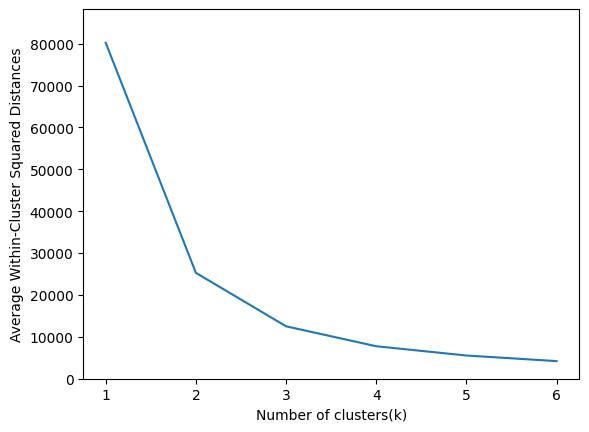

In [ ]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=0).fit(cluster_model4_df)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

### K means model

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(cluster_model4_df)
cluster_model4_df['cluster'] = kmeans.labels_
# Cluster membership
memb = pd.Series(kmeans.labels_, index=cluster_model4_df.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  fluconazole, enalapril maleate, clindamycin hcl, ropinirole hcl, amoxicillin, amoxicillin, cephalexin, famotidine, diclofenac sodium, azithromycin, methylprednisolone, potassium chloride, duloxetine hcl, trazodone hcl, warfarin sodium, tramadol hcl, triamcinolone acetonide, atenolol, metformin hcl, benazepril hcl, clindamycin hcl, lamotrigine, pen needle, diabetic, hydrocodone/acetaminophen, ibuprofen, ondansetron hcl, calcitriol, metformin hcl, sulfamethoxazole/trimethoprim, oxycodone hcl, potassium chloride, ondansetron, clonidine hcl, chlorhexidine gluconate, omeprazole, acarbose, carisoprodol, fluoxetine hcl, pravastatin sodium, allopurinol, losartan/hydrochlorothiazide, diazepam, tizanidine hcl, lisinopril, lorazepam, lisinopril, losartan potassium, meclizine hcl, ciprofloxacin hcl, mirtazapine, cephalexin, peg3350/sod sulf,bicarb,cl/kcl, risperidone, buspirone hcl, escitalopram oxalate, oxycodone hcl, fluconazole, trazodone hcl, amoxicillin/potassium clav, metformin hcl, que

### Scatter plot

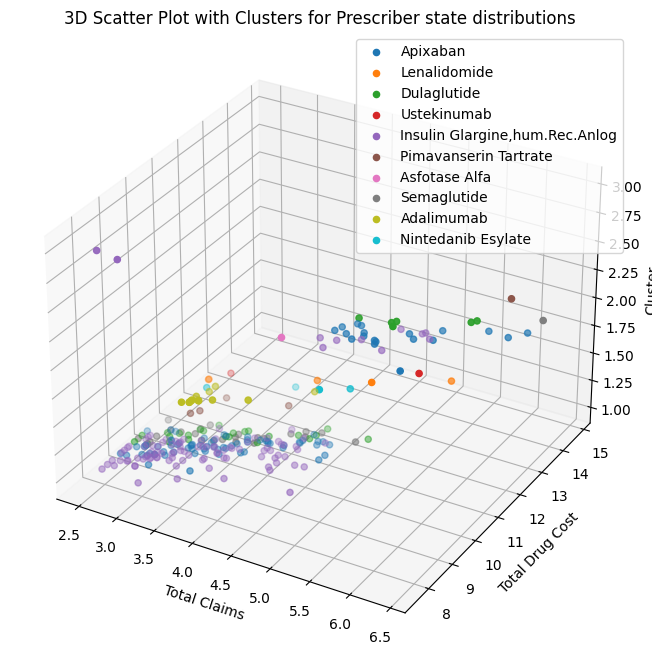

In [ ]:
cluster_model4_df.reset_index(drop=False, inplace=True)
# Creating a 3D scatter plot
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each drug
for drug in top_10_drugs_cost.index:
    drug_data = cluster_model4_df[cluster_model4_df['Gnrc_Name'] == drug]
    ax.scatter(drug_data['Tot_Clms'], drug_data['Tot_Drug_Cst'], drug_data['cluster'], label=drug)

# Labeling axes
ax.set_xlabel('Total Claims')
ax.set_ylabel('Total Drug Cost')
ax.set_zlabel('Cluster')
ax.set_title('3D Scatter Plot with Clusters for Prescriber state distributions')

# Adding legend for drug names
ax.legend()

plt.show()

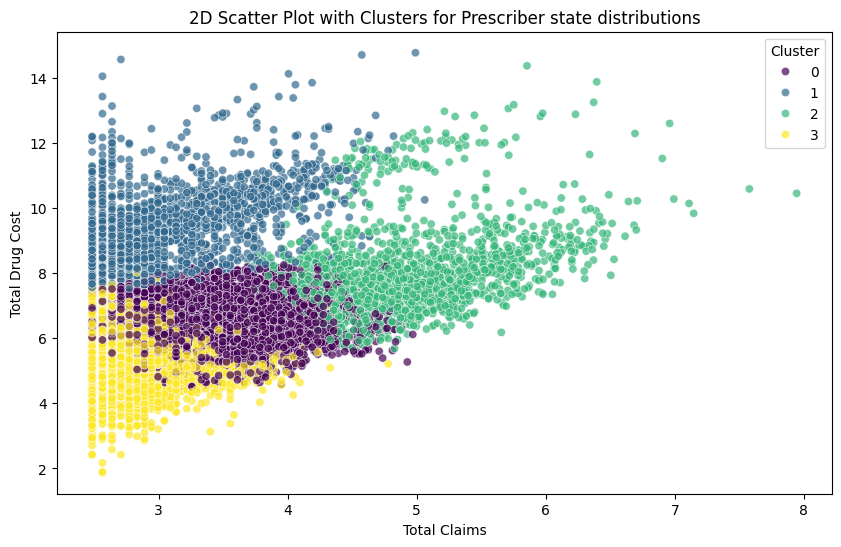

In [ ]:
# Creating a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tot_Clms', y='Tot_Drug_Cst', hue='cluster', data=cluster_model4_df, palette='viridis', alpha=0.7)

# Labeling axes
plt.xlabel('Total Claims')
plt.ylabel('Total Drug Cost')
plt.title('2D Scatter Plot with Clusters for Prescriber state distributions')

# Adding legend for cluster names
plt.legend(title='Cluster')

plt.show()


### Metrics

#### Entropy calculation

In [ ]:
cluster_model4_df.reset_index(drop=False, inplace=True)
cluster_model4_df.columns

Index(['Gnrc_Name', 'Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Prscrbr_State_Abrvtn_AK', 'Prscrbr_State_Abrvtn_AL',
       'Prscrbr_State_Abrvtn_AR', 'Prscrbr_State_Abrvtn_AZ',
       'Prscrbr_State_Abrvtn_CA', 'Prscrbr_State_Abrvtn_CO',
       'Prscrbr_State_Abrvtn_CT', 'Prscrbr_State_Abrvtn_DC',
       'Prscrbr_State_Abrvtn_DE', 'Prscrbr_State_Abrvtn_FL',
       'Prscrbr_State_Abrvtn_GA', 'Prscrbr_State_Abrvtn_HI',
       'Prscrbr_State_Abrvtn_IA', 'Prscrbr_State_Abrvtn_ID',
       'Prscrbr_State_Abrvtn_IL', 'Prscrbr_State_Abrvtn_IN',
       'Prscrbr_State_Abrvtn_KS', 'Prscrbr_State_Abrvtn_KY',
       'Prscrbr_State_Abrvtn_LA', 'Prscrbr_State_Abrvtn_MA',
       'Prscrbr_State_Abrvtn_MD', 'Prscrbr_State_Abrvtn_ME',
       'Prscrbr_State_Abrvtn_MI', 'Prscrbr_State_Abrvtn_MN',
       'Prscrbr_State_Abrvtn_MO', 'Prscrbr_State_Abrvtn_MS',
       'Prscrbr_State_Abrvtn_MT', 'Prscrbr_State_Abrvtn_NC',
       'Prscrbr_State_Abrvtn_ND', 'Prscrbr_State_

In [ ]:
# Group by 'cluster' and count the occurrences of each drug in each cluster
cluster_counts = cluster_model4_df.groupby('cluster')['Gnrc_Name'].value_counts().unstack(fill_value=0)

# Transpose the DataFrame to have clusters and counts as columns and drugs as rows
cluster_counts_transposed = cluster_counts.T

# Group by 'cluster' and count the occurrences of each drug in each cluster
cluster_counts = cluster_model4_df.groupby('cluster')['Gnrc_Name'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_drugs_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 7.652284615553182
Cluster 1: 6.667169654578689
Cluster 2: 7.434862253191285
Cluster 3: 7.175890158679816


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


#### entropy - disease

In [ ]:
df_impute['cluster_model4']=cluster_model4_df['cluster']

# Group by 'cluster' and count the occurrences of each disease in each cluster
cluster_counts = df_impute.groupby('cluster_model4')['disease'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_disease_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 6.171865605252009
Cluster 1: 5.5755613069705365
Cluster 2: 5.9772982875307
Cluster 3: 5.834600940347278


/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


#### Entropy - region

In [ ]:
# Group by 'cluster' and count the occurrences of each disease in each cluster
cluster_counts = df_impute.groupby('cluster_model4')['Region'].value_counts().unstack(fill_value=0)

# Calculate the total count of drugs in each cluster
total_disease_in_cluster = cluster_counts.sum(axis=1)

# Calculate the probability of each drug in each cluster
cluster_probabilities = cluster_counts.div(total_drugs_in_cluster, axis=0)

# Transpose the DataFrame to have drugs as rows and clusters as columns
cluster_probabilities_transposed = cluster_probabilities.T

# Calculate the entropy for each cluster
cluster_entropies = -(cluster_probabilities_transposed * np.log2(cluster_probabilities_transposed)).fillna(0)

# Sum the entropies for each cluster
cluster_entropies_sum = cluster_entropies.sum(axis=0)

# Print the entropy for each cluster
print("Entropy for each cluster:")
for cluster, entropy in cluster_entropies_sum.items():
    print(f"Cluster {cluster}: {entropy}")

Entropy for each cluster:
Cluster 0: 2.427608490166577
Cluster 1: 2.431186327428653
Cluster 2: 2.4228243584338127
Cluster 3: 2.4118865111244046


   Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  Tot_30day_Fills  \
0     2.824         5.240          5.882      2.197            3.023   
1     4.947         8.049          8.933      3.739            5.594   
2     3.487         6.434          7.356      2.362            4.063   
3     3.149         9.560          6.731      2.098            3.444   

   Prscrbr_State_Abrvtn_AK  Prscrbr_State_Abrvtn_AL  Prscrbr_State_Abrvtn_AR  \
0                2.186e-03                    0.007                    0.013   
1                6.270e-04                    0.018                    0.016   
2                4.195e-03                    0.009                    0.015   
3                6.325e-04                    0.011                    0.010   

   Prscrbr_State_Abrvtn_AZ  Prscrbr_State_Abrvtn_CA  ...  \
0                    0.013                    0.106  ...   
1                    0.025                    0.078  ...   
2                    0.010                    0.098  ...  

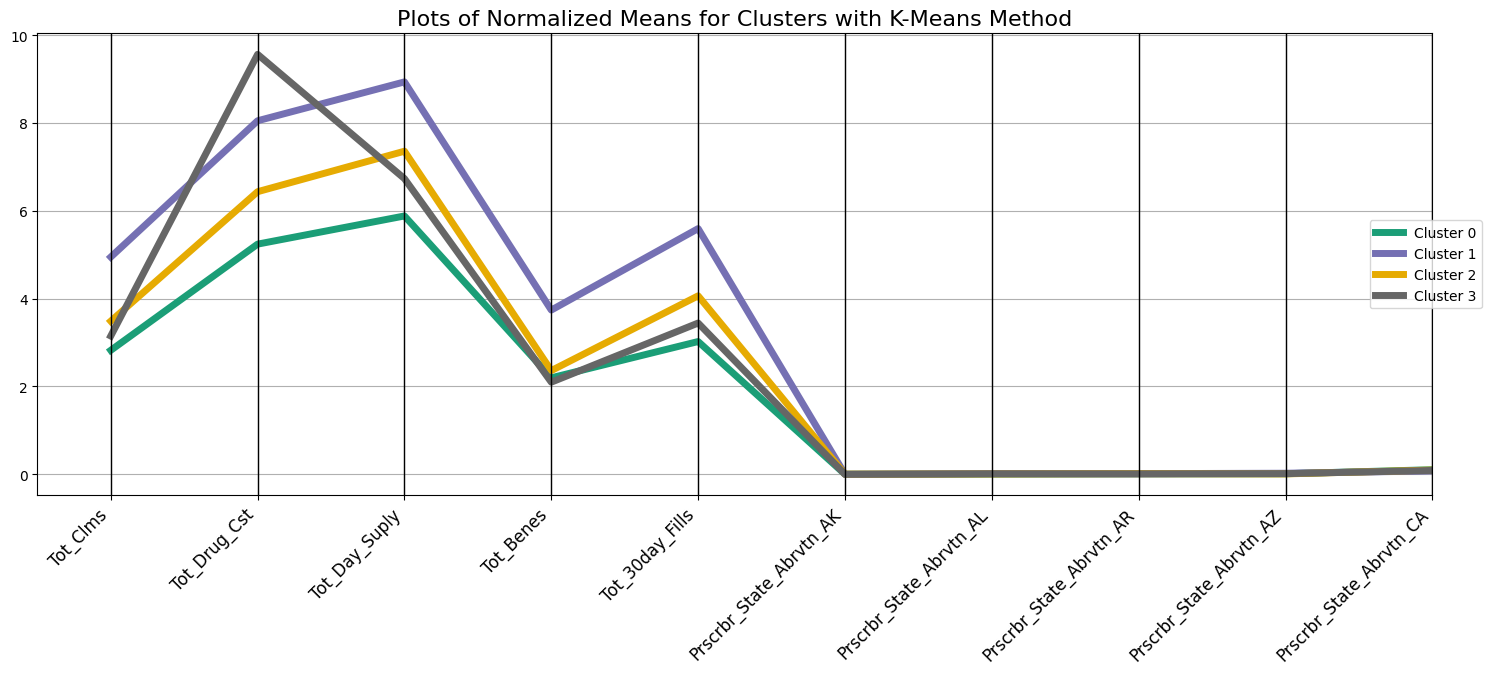

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Prscrbr_State_Abrvtn_AK', 'Prscrbr_State_Abrvtn_AL',
       'Prscrbr_State_Abrvtn_AR', 'Prscrbr_State_Abrvtn_AZ',
       'Prscrbr_State_Abrvtn_CA', 'Prscrbr_State_Abrvtn_CO',
       'Prscrbr_State_Abrvtn_CT', 'Prscrbr_State_Abrvtn_DC',
       'Prscrbr_State_Abrvtn_DE', 'Prscrbr_State_Abrvtn_FL',
       'Prscrbr_State_Abrvtn_GA', 'Prscrbr_State_Abrvtn_HI',
       'Prscrbr_State_Abrvtn_IA', 'Prscrbr_State_Abrvtn_ID',
       'Prscrbr_State_Abrvtn_IL', 'Prscrbr_State_Abrvtn_IN',
       'Prscrbr_State_Abrvtn_KS', 'Prscrbr_State_Abrvtn_KY',
       'Prscrbr_State_Abrvtn_LA', 'Prscrbr_State_Abrvtn_MA',
       'Prscrbr_State_Abrvtn_MD', 'Prscrbr_State_Abrvtn_ME',
       'Prscrbr_State_Abrvtn_MI', 'Prscrbr_State_Abrvtn_MN',
       'Prscrbr_State_Abrvtn_MO', 'Prscrbr_State_Abrvtn_MS',
       'Prscrbr_State_Abrvtn_MT', 'Prscrbr_State_Abrvtn_NC',
       'Prscrbr_State_Abrvtn_ND', 'Prscrbr_State_Abrvtn_NE',
       'Prscrbr_State_Abrvtn_NH', 'Prscrbr_State_Abrvtn_NJ',
       'Prscrbr_State_Abrvtn_NM', 'Prscrbr_State_Abrvtn_NV',
       'Prscrbr_State_Abrvtn_NY', 'Prscrbr_State_Abrvtn_OH',
       'Prscrbr_State_Abrvtn_OK', 'Prscrbr_State_Abrvtn_OR',
       'Prscrbr_State_Abrvtn_PA', 'Prscrbr_State_Abrvtn_PR',
       'Prscrbr_State_Abrvtn_RI', 'Prscrbr_State_Abrvtn_SC',
       'Prscrbr_State_Abrvtn_SD', 'Prscrbr_State_Abrvtn_TN',
       'Prscrbr_State_Abrvtn_TX', 'Prscrbr_State_Abrvtn_UT',
       'Prscrbr_State_Abrvtn_VA', 'Prscrbr_State_Abrvtn_VT',
       'Prscrbr_State_Abrvtn_WA', 'Prscrbr_State_Abrvtn_WI',
       'Prscrbr_State_Abrvtn_WV', 'Prscrbr_State_Abrvtn_WY',
       ])
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals.
centroids['Cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
pd.set_option('display.precision', 3)

#Add 'Cluster number' column
pd.set_option('display.precision', 3)
print(centroids)

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(18, 6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='Cluster',
                          colormap='Dark2', linewidth=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)  # Adjust label rotation and font size
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5, 9)
plt.title('Plots of Normalized Means for Clusters with K-Means Method', fontsize=16)  # Adjust title font size
plt.show()

In [ ]:
withinClusterSS = [0] * 4
clusterCount = [0] * 4
for cluster, distance in zip(kmeans.labels_, kmeans.transform(cluster_model4_df[['Tot_Clms','Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Prscrbr_State_Abrvtn_AK', 'Prscrbr_State_Abrvtn_AL',
       'Prscrbr_State_Abrvtn_AR', 'Prscrbr_State_Abrvtn_AZ',
       'Prscrbr_State_Abrvtn_CA', 'Prscrbr_State_Abrvtn_CO',
       'Prscrbr_State_Abrvtn_CT', 'Prscrbr_State_Abrvtn_DC',
       'Prscrbr_State_Abrvtn_DE', 'Prscrbr_State_Abrvtn_FL',
       'Prscrbr_State_Abrvtn_GA', 'Prscrbr_State_Abrvtn_HI',
       'Prscrbr_State_Abrvtn_IA', 'Prscrbr_State_Abrvtn_ID',
       'Prscrbr_State_Abrvtn_IL', 'Prscrbr_State_Abrvtn_IN',
       'Prscrbr_State_Abrvtn_KS', 'Prscrbr_State_Abrvtn_KY',
       'Prscrbr_State_Abrvtn_LA', 'Prscrbr_State_Abrvtn_MA',
       'Prscrbr_State_Abrvtn_MD', 'Prscrbr_State_Abrvtn_ME',
       'Prscrbr_State_Abrvtn_MI', 'Prscrbr_State_Abrvtn_MN',
       'Prscrbr_State_Abrvtn_MO', 'Prscrbr_State_Abrvtn_MS',
       'Prscrbr_State_Abrvtn_MT', 'Prscrbr_State_Abrvtn_NC',
       'Prscrbr_State_Abrvtn_ND', 'Prscrbr_State_Abrvtn_NE',
       'Prscrbr_State_Abrvtn_NH', 'Prscrbr_State_Abrvtn_NJ',
       'Prscrbr_State_Abrvtn_NM', 'Prscrbr_State_Abrvtn_NV',
       'Prscrbr_State_Abrvtn_NY', 'Prscrbr_State_Abrvtn_OH',
       'Prscrbr_State_Abrvtn_OK', 'Prscrbr_State_Abrvtn_OR',
       'Prscrbr_State_Abrvtn_PA', 'Prscrbr_State_Abrvtn_PR',
       'Prscrbr_State_Abrvtn_RI', 'Prscrbr_State_Abrvtn_SC',
       'Prscrbr_State_Abrvtn_SD', 'Prscrbr_State_Abrvtn_TN',
       'Prscrbr_State_Abrvtn_TX', 'Prscrbr_State_Abrvtn_UT',
       'Prscrbr_State_Abrvtn_VA', 'Prscrbr_State_Abrvtn_VT',
       'Prscrbr_State_Abrvtn_WA', 'Prscrbr_State_Abrvtn_WI',
       'Prscrbr_State_Abrvtn_WV', 'Prscrbr_State_Abrvtn_WY'
       ]])):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1

for cluster, SS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster,
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (3205 members): 9165.24 within cluster
Cluster 1 (1594 members): 6811.19 within cluster
Cluster 2 (3574 members): 9179.33 within cluster
Cluster 3 (1581 members): 5675.71 within cluster


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')).sum(axis=0))

0    12.246
1    13.133
2     8.932
3    11.918
dtype: float64


In [ ]:
# Add the 'Tot_Drug_Cst' column to cluster_model1_df
cluster_model4_df['Tot_Drug_Cst_new'] = df_impute['Tot_Drug_Cst']

# Calculate average drug cost for each cluster
average_drug_cost_per_cluster = cluster_model4_df.groupby('cluster')['Tot_Drug_Cst_new'].mean()

# Calculate total drug cost for each cluster
total_drug_cost_per_cluster = cluster_model4_df.groupby('cluster')['Tot_Drug_Cst_new'].sum()

# Print the results
print("Average Drug Cost for Each Cluster:")
print(average_drug_cost_per_cluster)

# Print the results
print("Total Drug Cost for Each Cluster:")
print(total_drug_cost_per_cluster)

Average Drug Cost for Each Cluster:
cluster
0      274.811
1    14586.534
2      807.402
3    36729.091
Name: Tot_Drug_Cst_new, dtype: float64
Total Drug Cost for Each Cluster:
cluster
0    8.808e+05
1    2.325e+07
2    2.886e+06
3    5.807e+07
Name: Tot_Drug_Cst_new, dtype: float64


### Overlap between clusters

In [ ]:
# Group by cluster and aggregate unique drug names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model4')['Gnrc_Name'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model4')['Gnrc_Name'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 373 unique drugs
0.9 % sodium chloride, acarbose, acetaminophen with codeine, acetazolamide, acetylcysteine, acyclovir, albuterol sulfate, alendronate sodium, alfuzosin hcl, allopurinol, alprazolam, amantadine hcl, amiloride hcl, amiodarone hcl, amitriptyline hcl, amlodipine besylate, amlodipine besylate/benazepril, ammonium lactate, amoxicillin, amoxicillin/potassium clav, ampicillin trihydrate, anastrozole, aripiprazole, armodafinil, atenolol, atomoxetine hcl, atorvastatin calcium, azelastine hcl, azelastine/fluticasone, azithromycin, baclofen, benazepril hcl, benzonatate, benztropine mesylate, betamethasone dipropionate, betamethasone valerate, betamethasone/propylene glyc, bethanechol chloride, bicalutamide, bisoprolol fumarate, brimonidine tartrate, bromocriptine mesylate, bumetanide, buprenorphine hcl, bupropion hcl, buspirone hcl, butalb/acetaminophen/caffeine, butalbit/acetamin/caff/codeine, butalbi

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()


Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (184 drugs):
levetiracetam, levothyroxine sodium, hydrocortisone, hydrocodone/acetaminophen, letrozole, fenofibrate, donepezil hcl, tolterodine tartrate, doxepin hcl, divalproex sodium, benztropine mesylate, spironolactone, betamethasone dipropionate, quetiapine fumarate, fludrocortisone acetate, clindamycin phosphate, pramipexole di-hcl, methylprednisolone, tamsulosin hcl, esomeprazole magnesium, alprazolam, latanoprost, famotidine, gabapentin, hydroxychloroquine sulfate, methotrexate sodium, amantadine hcl, perphenazine, labetalol hcl, finasteride, primidone, betamethasone valerate, clozapine, fluticasone propionate, metoprolol succinate, nortriptyline hcl, liothyronine sodium, digoxin, mupirocin, carbamazepine, oxybutynin chloride, simvastatin, warfarin sodium, lorazepam, oxycodone hcl/acetaminophen, aripiprazole, potassium chloride, albuterol sulfate, glipizide, baclofen, diclofenac sodium, meloxicam, t

In [ ]:
# Find the drug present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Drug present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")



Drug present in all clusters:
albuterol sulfate, amantadine hcl, aripiprazole, brimonidine tartrate, bumetanide, calcium acetate, carbamazepine, carbidopa/levodopa, clobetasol propionate, clozapine, diclofenac sodium, diltiazem hcl, divalproex sodium, doxepin hcl, doxycycline hyclate, duloxetine hcl, esomeprazole magnesium, estradiol, fluticasone propionate, hydrocortisone, insulin lispro, ipratropium bromide, lamotrigine, latanoprost, levetiracetam, levothyroxine sodium, memantine hcl, metformin hcl, methotrexate sodium, mometasone furoate, morphine sulfate, olanzapine, oxycodone hcl, pantoprazole sodium, pen needle, diabetic, pramipexole di-hcl, pregabalin, quetiapine fumarate, ranolazine, sucralfate, tolterodine tartrate, topiramate, venlafaxine hcl, zolpidem tartrate
Count: 44


In [ ]:
# Group by cluster and aggregate unique drug names
unique_drug_names_per_cluster = df_impute.groupby('cluster_model4')['disease'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = df_impute.groupby('cluster_model4')['disease'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 168 unique drugs
abdominal distension, abnormal uterine bleeding, abortion, acetaminophen overdose, acne, acromegaly, actinomycosis, acute coronary syndrome, acute lymphocytic leukemia, acute myeloid leukemia, acute otitis externa, addison's disease, adhd (attention deficit hyperactivity disorder), adjunct to antibiotic therapy, aggressive behavior, agitated state, agitation, aids related wasting, alcohol dependence, alcohol withdrawal, alkylating agent cystitis, allergic reactions, allergic rhinitis, allergic urticaria, alopecia, alport syndrome, alzheimer's disease, amenorrhea, amyloidosis, anal itching, androgenetic alopecia, anemia, megaloblastic, anesthesia, anesthetic adjunct, angina, angina pectoris prophylaxis, ankylosing spondylitis, anticholinesterase poisoning, antiphospholipid syndrome, anxiety, anxiety and stress, arrhythmia, ascites, aseptic necrosis, asthma, asthma, acute, asystole, atheroscl

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()

Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (103 drugs):
diabetes, type 2, allergic rhinitis, antiphospholipid syndrome, thalassemia, alzheimer's disease, tendonitis, hypokalemia, pain, chronic pain, underactive thyroid (hypothyroidism), vertigo, hyperthyroidism, asthma, aseptic necrosis, agitated state, arrhythmia, insomnia, diabetic kidney disease (diabetic nephropathy), migraine, polycystic kidney disease, pulmonary fibrosis, hyperlipoproteinemia type iia, elevated ldl, aggressive behavior, atrial fibrillation, acute otitis externa, hyperphosphatemia, tinea pedis, erythromelalgia, hyperhidrosis, atherosclerosis, diabetes mellitus, bipolar disorder, seizures (convulsions), acne, urinary incontinence, eye redness, edema, muscle spasm (involuntary hypertonicity), angina pectoris prophylaxis, gingivitis, asthma, acute, constipation, acute, mitral valve prolapse, actinomycosis, atopic dermatitis, urinary tract stones, breast cancer, skin and structure 

In [ ]:
# Find the drug present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Drug present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")

Drug present in all clusters:
acne, actinomycosis, acute coronary syndrome, adhd (attention deficit hyperactivity disorder), agitated state, agitation, alcohol dependence, alport syndrome, alzheimer's disease, angina, ankylosing spondylitis, anxiety, anxiety and stress, arrhythmia, asthma, asthma, acute, atopic dermatitis, atrial fibrillation, atrophic urethritis, autism, benign prostatic hyperplasia, bipolar disorder, borderline personality disorder, breast cancer, cardiovascular risk reduction, chronic pain, conjunctivitis, conjunctivitis, allergic, conjunctivitis, bacterial, dercum's disease, diabetes mellitus, diabetes, type 1, diabetes, type 2, ectopic pregnancy, edema, generalized anxiety disorder, gerd, glaucoma, open angle, hashimoto's disease (chronic lymphocytic thyroiditis), high blood pressure (hypertension), hyperphosphatemia, insomnia, migraine, mitral valve prolapse, muscle pain, occipital neuralgia, reflex sympathetic dystrophy syndrome, restless legs syndrome, rheumato

check to sort alpha the cluster result - overlap between generic  each cluster - could be used as a metric

## Model 4 db scan

### Create dummies

In [ ]:
del cluster_model5_df

In [ ]:
cluster_model5_df = pd.get_dummies(df_impute[['Prscrbr_Type_Src']],drop_first=False)
cluster_model5_df = pd.concat([df_impute[['Gnrc_Name','Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes','Tot_30day_Fills']],
                               cluster_model5_df], axis=1)
cluster_model5_df.set_index('Gnrc_Name', inplace=True)

In [ ]:
cluster_model5_df.columns

Index(['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Prscrbr_Type_Src_S', 'Prscrbr_Type_Src_T'],
      dtype='object')

### dbscan model

In [ ]:
# Define the columns to apply log transformation
columns_to_transform = ['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes', 'Tot_30day_Fills']

# Apply log transformation to the selected columns
for column in columns_to_transform:
    cluster_model5_df[column] = np.log(cluster_model5_df[column] + 1)  # Adding 1 to handle zero values

# Scale the numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_model5_df)

In [ ]:
from collections import Counter
from sklearn.cluster import DBSCAN

def dbscan_grid_search(X_data, lst, clst_count, eps_space=0.5,
                       min_samples_space=5, min_clust=0, max_clust=10):

    # Resetting lists
    dbscan_clusters = []
    cluster_count = []

    # Initialize total iterations counter
    n_iterations = 0
    print('hi')

    # Loop over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:

            # Create DBSCAN instance with current hyperparameters
            dbscan_grid = DBSCAN(eps=eps_val, min_samples=samples_val)

            # Fit DBSCAN model and predict clusters
            clusters = dbscan_grid.fit_predict(X=X_data)

            # Count the number of data points in each cluster
            cluster_count = Counter(clusters)

            # Compute the number of clusters
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

            # Increment total iterations counter
            n_iterations += 1

            # Append to lists if number of clusters is within specified range
            if min_clust <= n_clusters <= max_clust:
                dbscan_clusters.append([eps_val, samples_val, n_clusters])
                clst_count.append(cluster_count)

    # Print summary information
    print(f"Search Complete.\nYour list is now of length {len(lst)}.")
    print(f"Hyperparameter combinations checked: {n_iterations}.\n")


In [ ]:
# Apply DBSCAN clustering
eps = 0.5  # Adjust this value based on your data
min_samples = 50  # Adjust this value based on your data
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

# Add the cluster labels to your DataFrame
cluster_model5_df['cluster'] = clusters


### scatter plot

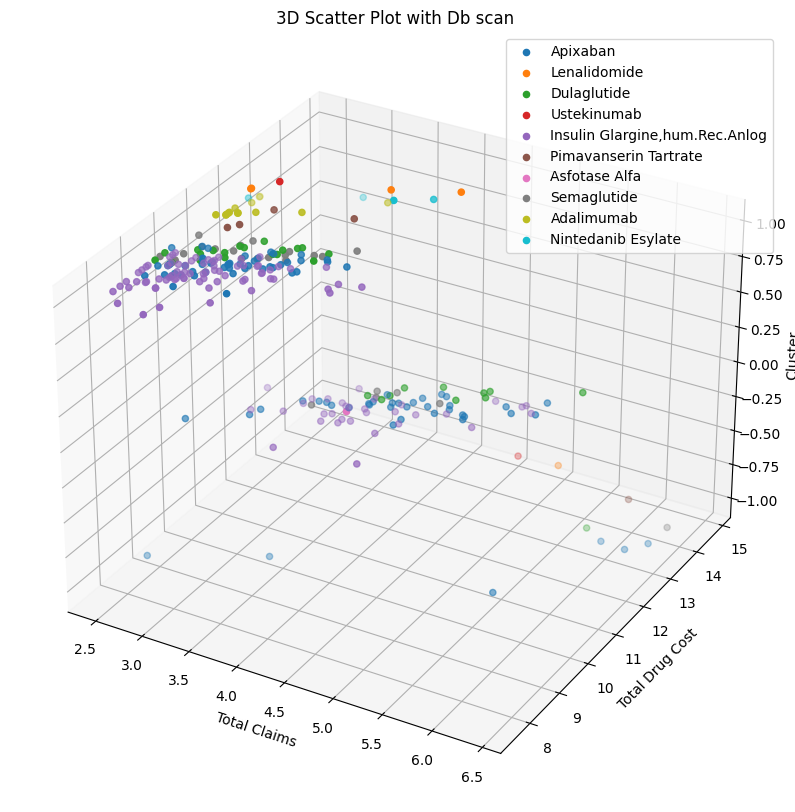

In [ ]:
cluster_model5_df.reset_index(drop=False, inplace=True)
# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each drug
for drug in top_10_drugs_cost.index:
    drug_data = cluster_model5_df[cluster_model5_df['Gnrc_Name'] == drug]
    ax.scatter(drug_data['Tot_Clms'], drug_data['Tot_Drug_Cst'], drug_data['cluster'], label=drug)

# Labeling axes
ax.set_xlabel('Total Claims')
ax.set_ylabel('Total Drug Cost')
ax.set_zlabel('Cluster')
ax.set_title('3D Scatter Plot with Db scan')

# Adding legend for drug names
ax.legend()

plt.show()

In [ ]:
# Creating a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tot_Clms', y='Tot_Drug_Cst', hue='cluster', data=cluster_model5_df, palette='viridis', alpha=0.7)

# Labeling axes
plt.xlabel('Total Claims')
plt.ylabel('Total Drug Cost')
plt.title('2D Scatter Plot with Clusters for Prescriber state distributions')

# Adding legend for cluster names
plt.legend(title='Cluster')

plt.show()


### Metrics

In [ ]:
X = cluster_model4_df[['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Prscrbr_Type_Src_S', 'Prscrbr_Type_Src_T']]
# Compute Silhouette Score
silhouette = silhouette_score(X, dbscan.labels_)
print("Silhouette Score:", silhouette)

# Compute Davies-Bouldin Score
davies_bouldin = davies_bouldin_score(X, dbscan.labels_)
print("Davies-Bouldin Score:", davies_bouldin)

# Count data points in each cluster
unique_labels = np.unique(dbscan.labels_)
for label in unique_labels:
    count = np.sum(dbscan.labels_ == label)
    print("Cluster {}: {} data points".format(label, count))


Silhouette Score: -0.13482589366803605
Davies-Bouldin Score: 2.3818943627040152
Cluster -1: 222 data points
Cluster 0: 4098 data points
Cluster 1: 5592 data points
Cluster 2: 76 data points
Cluster 3: 6 data points
Cluster 4: 6 data points


In [ ]:
cluster_model4_df.columns

Index(['Gnrc_Name', 'Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Region_Midwest', 'Region_North East',
       'Region_Other', 'Region_South', 'Region_West', 'Prscrbr_Type_Src_S',
       'Prscrbr_Type_Src_T', 'cluster'],
      dtype='object')

1. check the region with 'others'
2. try different transformation and see if the patterns are same
3. additional metrics - like total cost -
4. result - about the best model and techniques
5. additional business metrics
6. try log + normal

## Model 1 - Top 10 drugs by cost

1. Identified top 10 drug by cost
2. created new field called 'top10drug' and identified whether each row belongs to top 10 drug or not(1 or 0)
3. created dummies for region and top10drug- newly created fields
3. applied log transforamtion on the skewed numerical variables
4. Optimal cluster calculation
5. K- means cluster using numerical variable and newly created variables
6. Calculated the metrics


In [ ]:
import pandas as pd
import requests

api_url = 'https://data.cms.gov/data-api/v1/dataset/ab29d858-269a-4d97-908f-a26b1cf95f61/data'
target_records = 10000

# Set up parameters for pagination and distinct
offset = 0
size = 1000  # API limit
distinct = 1

data = []

while len(data) < target_records:
    params = {
        'offset': offset,
        'size': size,
        'distinct': distinct
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        page_data = response.json()

        # Check for duplicates and non-NaN values in 'Tot_Benes' before extending the data
        new_records = [record for record in page_data if record not in data and 'Tot_Benes' in record and pd.notna(record['Tot_Benes'])]
        data.extend(new_records)

        # Check if there are more pages
        if len(page_data) < size:
            break
        else:
            offset += size
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        break

# Ensure you have at least the required number of records
data = data[:target_records]

# Create DataFrame with the desired number of records
df = pd.DataFrame(data)

# Display the DataFrame
print("DataFrame with 10,000 records where 'Tot_Benes' has any value other than NaN:")
print(df.head())


DataFrame with 10,000 records where 'Tot_Benes' has any value other than NaN:
  Prscrbr_NPI Prscrbr_Last_Org_Name Prscrbr_First_Name Prscrbr_City  \
0  1003000126             Enkeshafi            Ardalan     Bethesda   
1  1003000126             Enkeshafi            Ardalan     Bethesda   
2  1003000126             Enkeshafi            Ardalan     Bethesda   
3  1003000126             Enkeshafi            Ardalan     Bethesda   
4  1003000126             Enkeshafi            Ardalan     Bethesda   

  Prscrbr_State_Abrvtn Prscrbr_State_FIPS       Prscrbr_Type Prscrbr_Type_Src  \
0                   MD                 24  Internal Medicine                S   
1                   MD                 24  Internal Medicine                S   
2                   MD                 24  Internal Medicine                S   
3                   MD                 24  Internal Medicine                S   
4                   MD                 24  Internal Medicine                S   

        

In [ ]:
# Check the missing values after dropping
missing_values = df.isnull().sum()
missing_values

Prscrbr_NPI              0
Prscrbr_Last_Org_Name    0
Prscrbr_First_Name       0
Prscrbr_City             0
Prscrbr_State_Abrvtn     0
Prscrbr_State_FIPS       0
Prscrbr_Type             0
Prscrbr_Type_Src         0
Brnd_Name                0
Gnrc_Name                0
Tot_Clms                 0
Tot_30day_Fills          0
Tot_Day_Suply            0
Tot_Drug_Cst             0
Tot_Benes                0
GE65_Sprsn_Flag          0
GE65_Tot_Clms            0
GE65_Tot_30day_Fills     0
GE65_Tot_Drug_Cst        0
GE65_Tot_Day_Suply       0
GE65_Bene_Sprsn_Flag     0
GE65_Tot_Benes           0
dtype: int64

In [ ]:
# Remove duplicate records and keep only the original occurrences
df_no_duplicates = df.drop_duplicates()

# Display the DataFrame without duplicates
print("DataFrame without Duplicates:")
print(len(df_no_duplicates))


DataFrame without Duplicates:
10000


In [ ]:
df.shape

(10000, 22)

Map 1 to top 10 drug by cost

In [ ]:
# Group the data by generic name and sum the total cost and total claims
grouped_data = df.groupby('Gnrc_Name').agg({'Tot_Drug_Cst': 'sum', 'Tot_Clms': 'sum'})

# Find the top 10 drugs by total cost
top_10_drugs_cost = grouped_data.nlargest(10, 'Tot_Drug_Cst')

# Create a new column 'Top10Drug' and set it to 'Other' by default
df['Top10Drug'] = 0

# Set the top 10 drug label for each row
df.loc[df['Gnrc_Name'].isin(top_10_drugs_cost.index), 'Top10Drug'] = 1

TypeError: Column 'Tot_Drug_Cst' has dtype object, cannot use method 'nlargest' with this dtype

### Create dummies

for 'Region', 'Top10Drug'

In [ ]:
del cluster_model1_df

NameError: name 'cluster_df' is not defined

In [ ]:
cluster_model1_df = pd.get_dummies(df_impute[['Region','Top10Drug']],drop_first=False)
cluster_model1_df = pd.concat([df_impute[['Gnrc_Name','Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes','Tot_30day_Fills']],
                               cluster_model1_df], axis=1)
cluster_model1_df.set_index('Gnrc_Name', inplace=True)

In [ ]:
cluster_model1_df.columns

Index(['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West'],
      dtype='object')

### Normalize the data columns

log Transformation

In [ ]:
# Define the columns to apply log transformation
columns_to_transform = ['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes', 'Tot_30day_Fills']

# Apply log transformation to the selected columns
for column in columns_to_transform:
    cluster_model1_df[column] = np.log(cluster_model1_df[column] + 1)  # Adding 1 to handle zero values

cluster_model1_df.head()

Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  \
Gnrc_Name                                                                  
Potassium Chloride      4.700480      8.968666       8.694670   3.496508   
Fluconazole             2.708050      4.112184       3.295837   1.945910   
Acyclovir               4.043051      7.444214       7.916078   2.995732   
Fluticasone/Vilanterol  3.091042      9.111539       6.538140   1.945910   
Enalapril Maleate       2.639057      5.682491       6.538140   1.945910   

                        Tot_30day_Fills  Top10Drug  Region_Midwest  \
Gnrc_Name                                                            
Potassium Chloride             5.298317          0               0   
Fluconazole                    2.708050          0               1   
Acyclovir                      4.564348          0               0   
Fluticasone/Vilanterol         3.178054          0               1   
Enalapril Maleate              3.178054          0               0   

                        Region_Northeast  Region_South  Region_Southeast  \
Gnrc_Name                                                                  
Potassium Chloride                     0             0                 1   
Fluconazole                            0             0                 0   
Acyclovir                              0             0                 0   
Fluticasone/Vilanterol                 0             0                 0   
Enalapril Maleate                      0             0                 1   

                        Region_Southwest  Region_West  
Gnrc_Name                                              
Potassium Chloride                     0            0  
Fluconazole                            0            0  
Acyclovir                              1            0  
Fluticasone/Vilanterol                 0            0  
Enalapril Maleate                      0            0

In [ ]:
cluster_model1_df.shape

(10000, 12)

### Optimal number of clusters

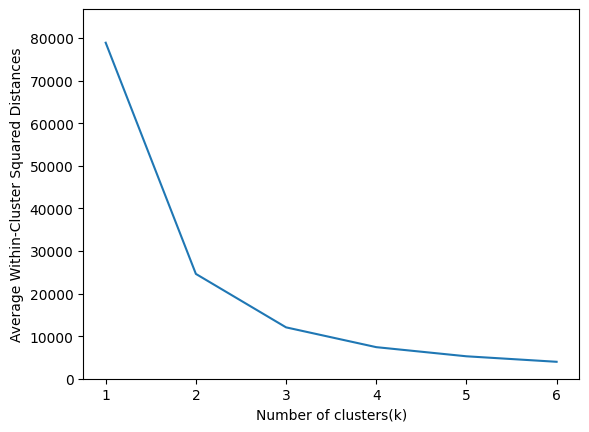

In [ ]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10, random_state=0).fit(cluster_model1_df)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

### K-Means model

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(cluster_model1_df)
cluster_model1_df['cluster'] = kmeans.labels_
# Cluster membership
memb = pd.Series(kmeans.labels_, index=cluster_model1_df.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  Potassium Chloride, Lisinopril, Carbidopa/Levodopa, Omeprazole, Latanoprost, Metformin Hcl, Alprazolam, Latanoprost, Furosemide, Lisinopril, Fludrocortisone Acetate, Oxycodone Hcl/Acetaminophen, Rosuvastatin Calcium, Metoprolol Succinate, Temazepam, Hydrochlorothiazide, Lisinopril, Brimonidine Tartrate, Lisinopril, Levothyroxine Sodium, Estradiol, Ketoconazole, Levothyroxine Sodium, Dulaglutide, Hydrochlorothiazide, Gabapentin, Amantadine Hcl, Atorvastatin Calcium, Losartan Potassium, Omeprazole, Timolol Maleate, Dorzolamide Hcl/Timolol Maleat, Amlodipine Besylate, Potassium Chloride, Metoprolol Succinate, Omeprazole, Alprazolam, Cyclosporine, Pregabalin, Metoprolol Succinate, Furosemide, Furosemide, Brimonidine Tartrate, Escitalopram Oxalate, Sertraline Hcl, Clopidogrel Bisulfate, Ezetimibe, Netarsudil Mesylate, Fluoxetine Hcl, Bupropion Hcl, Amlodipine Besylate, Repaglinide, Omeprazole, Sacubitril/Valsartan, Gabapentin, Carbidopa/Levodopa, Rosuvastatin Calcium, Escitalopram Oxal

### Overlap between clusters

In [ ]:
del cluster_drugs_df
del unique_drug_names_per_cluster
del unique_drugs_per_cluster
del drug_in_all_clusters
del count_drug_in_all_clusters
del drug_names_per_cluster

In [ ]:
# Get the cluster labels from KMeans
kmeans_labels = kmeans.labels_

# Create a DataFrame to hold the cluster labels and drug names
cluster_drugs_df = pd.DataFrame({'Cluster': kmeans_labels, 'Gnrc_Name': cluster_model1_df.index})

# Group by cluster and aggregate unique drug names
unique_drug_names_per_cluster = cluster_drugs_df.groupby('Cluster')['Gnrc_Name'].unique()

# Count the number of unique drugs in each cluster
unique_drugs_per_cluster = cluster_drugs_df.groupby('Cluster')['Gnrc_Name'].nunique()

# Print the number of unique drugs and the unique drug names for each cluster
print("Number of unique drugs in each cluster and sorted unique drug names:")
for cluster, drugs_in_cluster in unique_drug_names_per_cluster.items():
    num_unique_drugs = unique_drugs_per_cluster.loc[cluster]
    print(f"Cluster {cluster}: {num_unique_drugs} unique drugs")
    sorted_drugs = sorted(drugs_in_cluster)
    print(", ".join(sorted_drugs))

Number of unique drugs in each cluster and sorted unique drug names:
Cluster 0: 229 unique drugs
Albuterol Sulfate, Alcohol Antiseptic Pads, Alendronate Sodium, Alirocumab, Allopurinol, Alprazolam, Amantadine Hcl, Amiodarone Hcl, Amlodipine Besylate, Amlodipine Besylate/Valsartan, Amoxicillin, Anastrozole, Apixaban, Aripiprazole, Atenolol, Atorvastatin Calcium, Azelastine Hcl, Azithromycin, Baclofen, Benazepril Hcl, Benztropine Mesylate, Besifloxacin Hcl, Betamethasone Dipropionate, Betamethasone Valerate, Betamethasone/Propylene Glyc, Bimatoprost, Bisoprolol Fumarate, Brimonidine Tartrate, Brimonidine Tartrate/Timolol, Bromfenac Sodium, Budesonide/Formoterol Fumarate, Bumetanide, Buprenorphine Hcl/Naloxone Hcl, Bupropion Hcl, Buspirone Hcl, Calcium Acetate, Carbamazepine, Carbidopa/Levodopa, Carvedilol, Celecoxib, Chlorhexidine Gluconate, Chlorthalidone, Ciclopirox, Cilostazol, Citalopram Hydrobromide, Clindamycin Phosphate, Clobetasol Propionate, Clonazepam, Clopidogrel Bisulfate, Cl

In [ ]:
cluster_drugs_df

Cluster               Gnrc_Name
0           0      Potassium Chloride
1           3             Fluconazole
2           0               Acyclovir
3           3  Fluticasone/Vilanterol
4           0       Enalapril Maleate
...       ...                     ...
9995        0              Lisinopril
9996        0                Apixaban
9997        3              Famotidine
9998        3     Haloperidol Lactate
9999        1           Nebivolol Hcl

[10000 rows x 2 columns]

In [ ]:
# Create sets of drug names for each cluster
drug_names_per_cluster = [set(drugs) for drugs in unique_drug_names_per_cluster]

# Find the overlap of drug names between clusters
overlap_between_clusters = []
for i in range(len(drug_names_per_cluster)):
    for j in range(i+1, len(drug_names_per_cluster)):
        overlap = drug_names_per_cluster[i].intersection(drug_names_per_cluster[j])
        overlap_count = len(overlap)
        overlap_between_clusters.append((i, j, overlap, overlap_count))

# Print the overlap between clusters
print("Overlap of drug names between clusters:")
for cluster1, cluster2, overlap, overlap_count in overlap_between_clusters:
    print(f"Overlap between Cluster {cluster1} and Cluster {cluster2} ({overlap_count} drugs):")
    print(", ".join(overlap))
    print()


Overlap of drug names between clusters:
Overlap between Cluster 0 and Cluster 1 (185 drugs):
Ketoconazole, Letrozole, Glimepiride, Venlafaxine Hcl, Betamethasone/Propylene Glyc, Tolterodine Tartrate, Trazodone Hcl, Enalapril Maleate, Doxycycline Monohydrate, Doxepin Hcl, Clozapine, Clopidogrel Bisulfate, Meloxicam, Prednisone, Bisoprolol Fumarate, Finasteride, Clindamycin Phosphate, Rivaroxaban, Triamterene/Hydrochlorothiazid, Hydralazine Hcl, Lamotrigine, Fenofibrate Nanocrystallized, Losartan/Hydrochlorothiazide, Clobetasol Propionate, Levetiracetam, Liothyronine Sodium, Donepezil Hcl, Sucralfate, Insulin Lispro, Mycophenolate Mofetil, Rivastigmine Tartrate, Moxifloxacin Hcl, Hydrocortisone, Spironolactone, Nebivolol Hcl, Alprazolam, Nifedipine, Warfarin Sodium, Hydrocodone/Acetaminophen, Pen Needle, Diabetic, Lisinopril, Amoxicillin, Morphine Sulfate, Methylprednisolone, Haloperidol, Methocarbamol, Olanzapine, Dorzolamide Hcl, Trimethoprim, Amantadine Hcl, Sertraline Hcl, Prednisolo

In [ ]:
# Find the drug present in all clusters
drug_in_all_clusters = set.intersection(*drug_names_per_cluster)

# Count of drugs present in all clusters
count_drug_in_all_clusters = len(drug_in_all_clusters)

# Print the drug present in all clusters and its count
print("Drug present in all clusters:")
print(", ".join(sorted(drug_in_all_clusters)))
print(f"Count: {count_drug_in_all_clusters}")



Drug present in all clusters:
Albuterol Sulfate, Amantadine Hcl, Aripiprazole, Brimonidine Tartrate, Bumetanide, Calcium Acetate, Carbamazepine, Carbidopa/Levodopa, Clobetasol Propionate, Clozapine, Diclofenac Sodium, Diltiazem Hcl, Divalproex Sodium, Doxepin Hcl, Doxycycline Hyclate, Duloxetine Hcl, Esomeprazole Magnesium, Estradiol, Fluticasone Propionate, Hydrocortisone, Insulin Lispro, Ipratropium Bromide, Lamotrigine, Latanoprost, Levetiracetam, Levothyroxine Sodium, Memantine Hcl, Metformin Hcl, Methotrexate Sodium, Mometasone Furoate, Morphine Sulfate, Olanzapine, Oxycodone Hcl, Pantoprazole Sodium, Pen Needle, Diabetic, Pramipexole Di-Hcl, Pregabalin, Quetiapine Fumarate, Ranolazine, Sucralfate, Tolterodine Tartrate, Topiramate, Venlafaxine Hcl, Zolpidem Tartrate
Count: 44


In [ ]:
top_10_drugs_cost

Tot_Drug_Cst  Tot_Clms
Gnrc_Name                                             
Apixaban                           4.971e+06      6103
Lenalidomide                       4.674e+06       269
Dulaglutide                        2.785e+06      1935
Ustekinumab                        2.761e+06       109
Insulin Glargine,hum.Rec.Anlog     2.730e+06      4217
Pimavanserin Tartrate              2.160e+06       430
Asfotase Alfa                      2.129e+06        14
Semaglutide                        2.003e+06      1365
Adalimumab                         1.711e+06       213
Nintedanib Esylate                 1.631e+06       140

In [ ]:
cluster_model1_df.reset_index(drop=False, inplace=True)

In [ ]:
cluster_model1_df.columns

Index(['Gnrc_Name', 'Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',
       'cluster'],
      dtype='object')

### 3D scatter plot

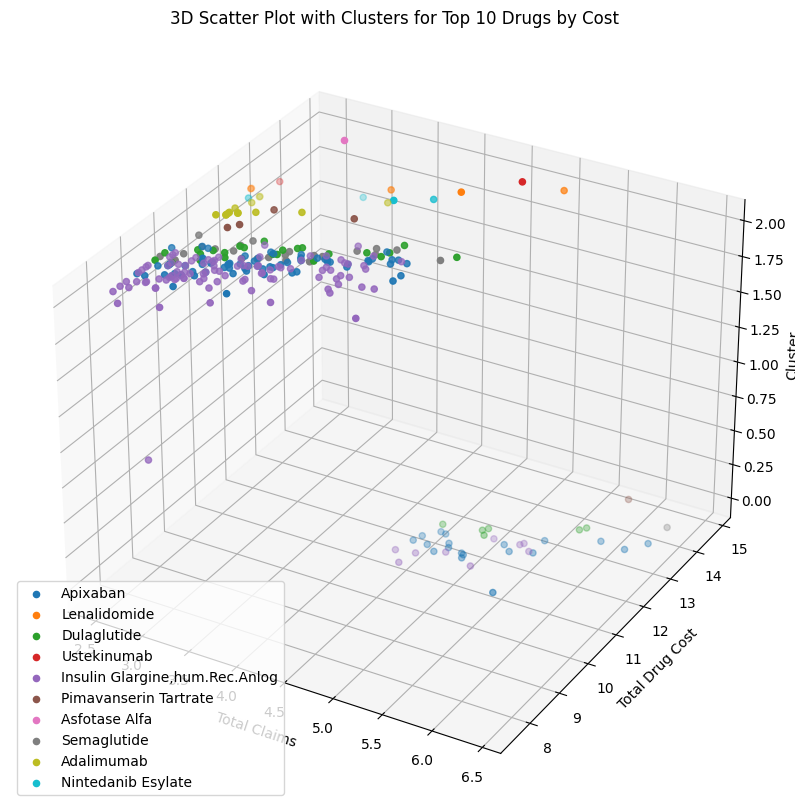

In [ ]:
# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each drug
for drug in top_10_drugs_cost.index:
    drug_data = cluster_model1_df[cluster_model1_df['Gnrc_Name'] == drug]
    ax.scatter(drug_data['Tot_Clms'], drug_data['Tot_Drug_Cst'], drug_data['cluster'], label=drug)

# Labeling axes
ax.set_xlabel('Total Claims')
ax.set_ylabel('Total Drug Cost')
ax.set_zlabel('Cluster')
ax.set_title('3D Scatter Plot with Clusters for Top 10 Drugs by Cost')

# Adding legend for drug names
ax.legend()

plt.show()



In [ ]:
# Creating a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tot_Clms', y='Tot_Drug_Cst', hue='cluster', data=cluster_model1_df, palette='viridis', alpha=0.7)

# Labeling axes
plt.xlabel('Total Claims')
plt.ylabel('Total Drug Cost')
plt.title('2D Scatter Plot with Clusters for Top 10 Drugs by Cost')

# Adding legend for cluster names
plt.legend(title='Cluster')

plt.show()


### Metrics

   Tot_Clms  Tot_Drug_Cst  Tot_Day_Suply  Tot_Benes  Tot_30day_Fills  \
0     4.946         8.050          8.932      3.739            5.593   
1     2.824         5.241          5.881      2.197            3.022   
2     3.152         9.571          6.733      2.098            3.446   
3     3.485         6.434          7.353      2.360            4.061   

   Top10Drug  Region_Midwest  Region_Northeast  Region_South  \
0  2.249e-02           0.196             0.194         0.049   
1  3.117e-04           0.175             0.211         0.047   
2  1.509e-01           0.193             0.231         0.037   
3 -6.384e-16           0.168             0.200         0.049   

   Region_Southeast  Region_Southwest  Region_West    Cluster  
0             0.275             0.113        0.165  Cluster 0  
1             0.256             0.099        0.209  Cluster 1  
2             0.231             0.107        0.195  Cluster 2  
3             0.260             0.097        0.220  Cluster 3 

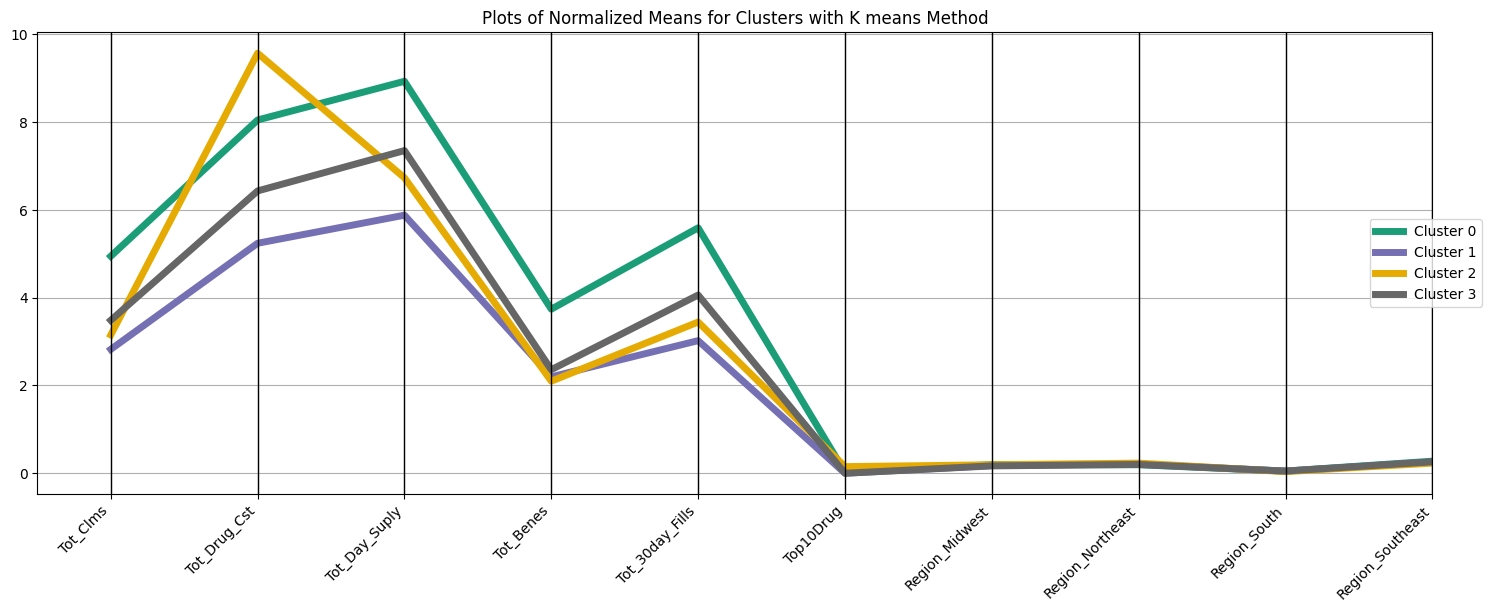

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West',])
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals.
centroids['Cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
pd.set_option('display.precision', 3)

#Add 'Cluster number' column
pd.set_option('display.precision', 3)
print(centroids)

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(18,6))
#fig = plt.gcf()
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='Cluster',
                          colormap='Dark2', linewidth=5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,9)
plt.title('Plots of Normalized Means for Clusters with K means Method')
plt.show()

In [ ]:
centroids.shape


(4, 13)

In [ ]:
withinClusterSS = [0] * 4
clusterCount = [0] * 4
for cluster, distance in zip(kmeans.labels_, kmeans.transform(cluster_model1_df[['Tot_Clms', 'Tot_Drug_Cst', 'Tot_Day_Suply', 'Tot_Benes',
       'Tot_30day_Fills', 'Top10Drug', 'Region_Midwest', 'Region_Northeast',
       'Region_South', 'Region_Southeast', 'Region_Southwest', 'Region_West']])):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1

for cluster, SS in enumerate(withinClusterSS):
    print('Cluster {} ({} members): {:5.2f} within cluster'.format(cluster,
        clusterCount[cluster], withinClusterSS[cluster]))

Cluster 0 (1599 members): 6620.85 within cluster
Cluster 1 (3211 members): 8671.15 within cluster
Cluster 2 (1604 members): 5709.35 within cluster
Cluster 3 (3586 members): 8643.84 within cluster


In [ ]:
# Calculate the total sum of squares (TSS)
TSS = sum(withinClusterSS)

# Calculate the between-cluster sum of squares (BCSS) for each cluster
BCSS_per_cluster = [TSS - wcss for wcss in withinClusterSS]

# Print BCSS for each cluster
for cluster, bcss in enumerate(BCSS_per_cluster):
    print(f"Cluster {cluster}: BCSS = {bcss:.2f}")


Cluster 0: BCSS = 23024.34
Cluster 1: BCSS = 20974.04
Cluster 2: BCSS = 23935.83
Cluster 3: BCSS = 21001.35


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')))


       0      1      2      3
0  0.000  5.541  4.207  3.390
1  5.541  0.000  4.450  2.266
2  4.207  4.450  0.000  3.289
3  3.390  2.266  3.289  0.000


In [ ]:
print(pd.DataFrame(pairwise.pairwise_distances(kmeans.cluster_centers_, metric='euclidean')).sum(axis=0))

0    13.137
1    12.256
2    11.945
3     8.945
dtype: float64


In [ ]:
# Add the 'Tot_Drug_Cst' column to cluster_model1_df
cluster_model1_df['Tot_Drug_Cst_new'] = df_impute['Tot_Drug_Cst']

# Calculate average drug cost for each cluster
average_drug_cost_per_cluster = cluster_model1_df.groupby('cluster')['Tot_Drug_Cst_new'].mean()

# Calculate total drug cost for each cluster
total_drug_cost_per_cluster = cluster_model1_df.groupby('cluster')['Tot_Drug_Cst_new'].sum()

# Print the results
print("Average Drug Cost for Each Cluster:")
print(average_drug_cost_per_cluster)

# Print the results
print("Total Drug Cost for Each Cluster:")
print(total_drug_cost_per_cluster)

Average Drug Cost for Each Cluster:
cluster
0    14662.512
1      275.252
2    36895.380
3      807.478
Name: Tot_Drug_Cst_new, dtype: float64
Total Drug Cost for Each Cluster:
cluster
0    2.345e+07
1    8.838e+05
2    5.918e+07
3    2.896e+06
Name: Tot_Drug_Cst_new, dtype: float64
